Links to Yelp dataset files : https://drive.google.com/drive/folders/15_pQBF8zIOnxXSaDx19DN8eU-lXrvIeW?usp=share_link https://drive.google.com/drive/folders/1-9SOeLW8g97fiX2On7_7Wm1ePt2pSnDU?usp=share_link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing...

In [ ]:
import pandas as pd
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import ndcg_score
np.random.seed(0)

In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
import re
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag

In [ ]:
save_path='/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/Yelp/'

In [ ]:
import torch
import gc
for i in range(10000):
  torch.cuda.empty_cache()
# del checkin_df
# del data
# del data_file


In [ ]:
gc.collect()

0

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/Yelp/Kaggle/"

In [ ]:
%cd /content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/Yelp/Kaggle/

/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/Yelp/Kaggle


In [ ]:
!kaggle datasets download -d yelp-dataset/yelp-dataset --unzip

100% 4.06G/4.07G [02:00<00:00, 27.4MB/s]
100% 4.07G/4.07G [02:00<00:00, 36.3MB/s]


In [ ]:
import json
import pandas as pd
data_file = open(save_path+"Kaggle/yelp_academic_dataset_business.json")
data = []
for line in data_file:
  data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

In [ ]:
business_df.attributes= business_df.attributes.apply(lambda y: np.nan if y==None else y)

In [ ]:
business_df.dropna(axis=0,inplace=True)

In [ ]:
business_df1=business_df[business_df['is_open']==1]

In [ ]:
business_df=business_df1[business_df1['review_count']>10]

In [ ]:
import json
import pandas as pd
data_file = open(save_path+"Kaggle/yelp_academic_dataset_tip.json")
data = []
for line in data_file:
  data.append(json.loads(line))
tip_df = pd.DataFrame(data)
data_file.close()

In [ ]:
tips_bus_ids=tip_df['business_id'].values
tips_user_ids= tip_df['user_id'].values

In [ ]:
business_df.drop(business_df.index[~business_df['business_id'].isin(tips_bus_ids)], inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
saved_bus_ids=os.listdir(save_path+'tips_bert_items_dfs/')

In [ ]:
len(saved_bus_ids)

48732

In [ ]:
new_saved_bus_ids=[]
for bus_id in saved_bus_ids:
  new_saved_bus_ids.append(bus_id[:-5])

In [ ]:
business_df.drop(business_df.index[~business_df['business_id'].isin(new_saved_bus_ids)], inplace=True)

In [ ]:
tip_df.drop(tip_df.index[~tip_df['business_id'].isin(new_saved_bus_ids)], inplace=True)
tip_df.drop(tip_df.index[~tip_df['business_id'].isin(business_df['business_id'].values)], inplace=True)

In [ ]:
tip_df['bus_user_id']=tip_df[['business_id','user_id']].apply(tuple, axis=1)

In [ ]:
tip_df

In [ ]:
business_df.reset_index(inplace=True)

In [ ]:
business_df.drop(['index'],axis=1,inplace=True)

In [ ]:
business_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
2,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
3,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
4,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50063,9U1Igcpe954LoWZRmNc-zg,Hand & Stone Massage And Facial Spa,"1100 S Columbus Blvd, Ste 24",Philadelphia,PA,19147,39.932756,-75.144504,3.0,32,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Day Spas, Beauty & Spas, Skin Care, Massage","{'Monday': '9:0-22:0', 'Tuesday': '9:0-22:0', ..."
50064,GeEveoOaU2YKD7jJtEfA_g,DeVons Jewelers,"13981 S Virginia St, 402A",Reno,NV,89511,39.404552,-119.750986,5.0,34,1,"{'BusinessParking': '{'garage': False, 'street...","Shopping, Watches, Jewelry","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."
50065,qQ7FHvkGEMqoPKKXPk4gjA,La Quinta by Wyndham NW Tucson Marana,6020 West Hospitality Rd,Tucson,AZ,85743,32.358587,-111.093308,2.5,67,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Hotels & Travel, Hotels, Event Planning & Serv...","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
50066,LJ4GjQ1HL6kqvIPpNUNNaQ,Shanti Yoga and Ayurveda,"1638 Pine St, Fl 1",Philadelphia,PA,19103,39.945966,-75.169666,4.5,39,1,"{'ByAppointmentOnly': 'True', 'GoodForKids': '...","Health & Medical, Yoga, Shopping, Naturopathic...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."


In [ ]:
bus_ids=business_df.business_id.values

In [ ]:
len(bus_ids)

48089

In [ ]:
# with open('badFiles.txt', 'r') as bf:
#   lines=bf.readlines()
#   for line in lines:
#     if len(line)>4:
#       try:
#         os.remove(save_path+'tips_bert_items_dfs/'+'{}.json'.format(line.replace('\n','')))
#       except FileNotFoundError:
#         print(line)

In [ ]:
# new_bus_ids=[]
# i=0
# for id in bus_ids:
#   if i%1000==0:
#     print(i)
#   i+=1
#   if i<43000:
#     continue
#   with open(save_path+'tips_bert_items_dfs/'+'{}.json'.format(id)) as fd:
#     lines= fd.readlines()
#     if len(lines[0])<5:
#       print(id)
#       # print(lines)
#     else:
#       new_bus_ids.append(id)
    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
s5cEDXoKrvD-coPgqifD8w
FbuQkR42LQ-8AZINSD7FQQ
RtdH6Inl8xG6RWl5PVwccg
zIFPcIZ_yqIr2Gb3dYZvfQ
U5vGEpfMzlHmdVMsaAxWAA
nCQnjq8uoY7YWGMwOxP2wA
sa0qlVEgdctgeWo8KkWEjw
zVoivXO64KO9-4UQlMhoPA
fiKriXSPJQLoDnMIucTXQQ
1Hd6GDCbsev3NUaynU8hFQ
B6wuW9wBR2qc3Q3fs4Ckkw
HznFRGROzuvVBeM5hrwZig
xS9q3oPQHaM4etfeSvFpew
OM2bY0wa1-mwECTO_zrZkw
7ogUy7wU7hwEm43pAtA8tQ
8SEX-Mx-ZC64g6laAEj2bg
cZwhdOCpa84XrpLQREOtaA
hNWf3Uz8M17e2qB3eBV8jg
wtMhl1OIcPBPc2qj-6_-OQ
oJbhXG2IldIhNFydRWjD7A
DsIeBV5j-1Y6X5BNnyjRzw
xEOMVwCzxjcmwIoxQ3sCBg
sbUASO4t6DMb2DygKN-scg
AZmxWOK3ov1-_9hPBzSIng
NDwoKO79_T49UEKVDlHd3A
W0ziF4eQxT_1KkgYDHWlcw
IjcDm_NIT0P4vxevx1obAg
krcU3vu-4xC_O5Zb0IXqJg
gGtvjhVT-Jojd1iGefopIg
wn-l6xkj9WZu_VnotRAMvA
KSR9Rv0Uea55YF-PNWXj1A
VP6khoAuw4HWtHUUhw7gkQ
hE2K63wovs5Po

In [ ]:
business_df

In [ ]:
# import json
# import pandas as pd
# data_file = open(save_path+"Kaggle/yelp_academic_dataset_review.json")
# data = []
# for line in data_file:
#   data.append(json.loads(line))
# review_df = pd.DataFrame(data)
# data_file.close()

In [ ]:
# review_df

In [ ]:
# review_df.drop(['useful','funny','cool','date'],axis=1,inplace=True)

In [ ]:
# review_df.drop(review_df.index[~review_df['business_id'].isin(bus_ids)], inplace=True)

In [ ]:
# review_df.drop(review_df.index[~review_df['business_id'].isin(tips_bus_ids)], inplace=True)

In [ ]:
# review_df.drop(review_df.index[~review_df['user_id'].isin(tips_user_ids)], inplace=True)

In [ ]:
# review_df

In [ ]:
# review_df.to_csv(save_path+'yelp_reviews.csv')

In [ ]:
review_df=pd.read_csv(save_path+'yelp_reviews.csv')

In [ ]:
# import json
# import pandas as pd
# data_file = open(save_path+"Kaggle/yelp_academic_dataset_user.json")
# data = []
# for line in data_file:
#   data.append(json.loads(line))
# user_df = pd.DataFrame(data)
# data_file.close()

In [ ]:
# user_df=user_df[user_df['review_count']>20]

In [ ]:
# user_df

In [ ]:
# user_ids=user_df['user_id'].values

In [ ]:
# user_ids

array(['qVc8ODYU5SZjKXVBgXdI7w', 'j14WgRoU_-2ZE1aw1dXrJg',
       '2WnXYQFK0hXEoTxPtV2zvg', ..., '_K4X0IBlwDSnClxOrOdxVw',
       'E7Stb54xluW_QabdPRwvog', 'fB3jbHi3m0L2KgGOxBv6uw'], dtype=object)

In [ ]:
# review_df.drop(review_df.index[~review_df['user_id'].isin(user_ids)], inplace=True)

In [ ]:
# review_df

In [ ]:
from sklearn import preprocessing
import numpy as np

In [ ]:
# min_max_scaler1 = preprocessing.MinMaxScaler(feature_range=(0,1))
# # min_max_scaler2 = preprocessing.MinMaxScaler(feature_range=(-1,0))
# latitudes=business_df['latitude'].values.reshape(-1, 1)
# longitudes=business_df['longitude'].values.reshape(-1, 1)
# # minmax1 = min_max_scaler1.fit_transform(latitudes)
# minmax2 = min_max_scaler1.fit_transform(longitudes)

In [ ]:
# business_df['normalized_latitude']=minmax1
# business_df['normalized_longitude']=minmax2

In [ ]:
business_df.drop(['name','address','city','state','postal_code'],axis=1,inplace=True)

In [ ]:
# business_df.drop(['latitude','longitude'],axis=1,inplace=True)

In [ ]:
# stars=business_df['stars'].values.reshape(-1, 1)
# minmax3 = min_max_scaler1.fit_transform(stars)
# business_df['normalized_stars']=minmax3

In [ ]:
# business_df.drop(['stars'],axis=1,inplace=True)

In [ ]:
business_df.drop(['is_open','review_count'],axis=1,inplace=True)

In [ ]:
business_df.head()

,business_id,latitude,longitude,stars,attributes,categories,hours
0,mpf3x-BjTdTEA3yCZrAYPw,38.551126,-90.335695,3.0,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
1,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,4.0,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
2,n_0UpQx1hsNbnPUSlodU8w,38.627695,-90.340465,2.5,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
3,il_Ro8jwPlHresjw9EGmBg,39.637133,-86.127217,2.5,"{'RestaurantsReservations': 'False', 'Restaura...","American (Traditional), Restaurants, Diners, B...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ..."
4,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,4.0,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."


In [ ]:
all_attributes=[]
values=[]
for attr in business_df['attributes'].values:
  for key in attr.keys():
    res=attr[key].replace('\'','\"').replace('False','-1').replace('True','1').replace('None','0').replace('none','0').replace('u','').replace('yes','1')
    # print(res)
    if '{' in res:
      # print(res)
      res = json.loads(res)
      all_attributes+=res.keys()
    elif '\"' not in res and int(res)<2:
      all_attributes.append(key)
all_attributes=list(set(all_attributes))

In [ ]:
len(all_attributes)

87

In [ ]:
attributes=[]
i=0
for attr in business_df['attributes'].values:
  att=np.zeros(87)
  for key in  attr.keys():
    res=attr[key].replace('\'','\"').replace('False','-1').replace('True','1').replace('None','0').replace('none','0').replace('u','')
    if '{' in res:
      res = json.loads(res)
      for key2 in res.keys():
        ind=all_attributes.index(key2)
        att[ind]=res[key2]
    elif '\"' not in res  and int(res)<2:
      ind=all_attributes.index(key)
      att[ind]=int(res)
  attributes.append(att)

In [ ]:
attributes_array=np.array(attributes)

In [ ]:
# normalized_attributes_array=preprocessing.scale(attributes_array)

In [ ]:
# normalized_attributes_array

In [ ]:
business_df.reset_index(inplace=True)

In [ ]:
business_df.drop(['index'],axis=1,inplace=True)

In [ ]:
business_df=pd.concat([business_df, pd.DataFrame(attributes_array,columns=all_attributes)], axis=1)

In [ ]:
business_df.drop(['attributes'],axis=1,inplace=True)

In [ ]:
business_df

,business_id,latitude,longitude,stars,categories,hours,lot,pscale,breakfast,asian,...,latenight,dj,vegan,satrday,divey,WiFi,glten-free,jkebox,Ambience,HasTV
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,4.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,4.0,"Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",-1.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0
2,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,4.5,"Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",-1.0,-1.0,-1.0,0.0,...,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
3,qhDdDeI3K4jy2KyzwFN53w,39.913820,-86.105739,4.0,"Shopping, Books, Mags, Music & Video, Bookstores","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9OG5YkX1g2GReZM0AskizA,39.476117,-119.789339,2.5,"Restaurants, Italian","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1.0,-1.0,-1.0,0.0,...,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16297,lCo7sEuxlfFeT-nAOR-sbA,30.005648,-90.157396,3.0,"IT Services & Computer Repair, Mobile Phones, ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16298,wVxXRFf10zTTAs11nr4xeA,40.032483,-75.214430,3.0,"Restaurants, Specialty Food, Food, Sandwiches,...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",1.0,-1.0,-1.0,0.0,...,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
16299,WXNag-tmudrFHFlfNLogWg,38.641988,-90.261655,4.0,"Health Markets, Specialty Food, Food, Grocery","{'Monday': '0:0-0:0', 'Tuesday': '7:0-22:0', '...",-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16300,w_4xUt-1AyY2ZwKtnjW0Xg,43.616590,-116.202383,4.5,"Bars, Gastropubs, Sandwiches, Nightlife, Resta...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",-1.0,-1.0,-1.0,0.0,...,1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,-1.0,0.0,1.0


In [ ]:
# all_categories=[]
# for cats in business_df['categories'].values:
#   all_cats=cats.split(',')
#   for cat in all_cats:
#     all_categories.append(cat.strip())
# all_categories=list(set(all_categories))

In [ ]:
# len(all_categories)

1193

In [ ]:
# categories=[]
# for cats in business_df['categories'].values:
#   cats_a=np.zeros(len(all_categories))
#   cats=cats.split(',')
#   for cat in cats:
#     ind=all_categories.index(cat.strip())
#     cats_a[ind]=1.0
#   categories.append(cats_a)

In [ ]:
# categories_array=np.array(categories)

In [ ]:
# business_df=pd.concat([business_df, pd.DataFrame(categories_array,columns=all_categories)], axis=1)

In [ ]:
business_df.drop(['categories'],axis=1,inplace=True)

In [ ]:
business_df

,business_id,latitude,longitude,stars,hours,lot,pscale,breakfast,asian,CoatCheck,...,latenight,dj,vegan,satrday,divey,WiFi,glten-free,jkebox,Ambience,HasTV
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,4.0,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,4.0,"{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",-1.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0
2,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,4.5,"{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",-1.0,-1.0,-1.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
3,qhDdDeI3K4jy2KyzwFN53w,39.913820,-86.105739,4.0,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9OG5YkX1g2GReZM0AskizA,39.476117,-119.789339,2.5,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1.0,-1.0,-1.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16297,lCo7sEuxlfFeT-nAOR-sbA,30.005648,-90.157396,3.0,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16298,wVxXRFf10zTTAs11nr4xeA,40.032483,-75.214430,3.0,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",1.0,-1.0,-1.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0
16299,WXNag-tmudrFHFlfNLogWg,38.641988,-90.261655,4.0,"{'Monday': '0:0-0:0', 'Tuesday': '7:0-22:0', '...",-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16300,w_4xUt-1AyY2ZwKtnjW0Xg,43.616590,-116.202383,4.5,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",-1.0,-1.0,-1.0,0.0,0.0,...,1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,-1.0,0.0,1.0


In [ ]:
all_hours=[]
for days in business_df['hours'].values:
  # print(days)
  all_hours+=days.values()
all_hours=list(set(all_hours))  

In [ ]:
days_dict={'Monday':0, 'Tuesday':1, 'Wednesday':2 , 'Thursday': 3 , 'Friday':4 , 'Saturday':5 , 'Sunday':6}

In [ ]:
all_days_hours=[]
for day in days_dict.keys():
  for i in range(24):
    all_days_hours.append(day+'-'+str(i))
print(all_days_hours)

['Monday-0', 'Monday-1', 'Monday-2', 'Monday-3', 'Monday-4', 'Monday-5', 'Monday-6', 'Monday-7', 'Monday-8', 'Monday-9', 'Monday-10', 'Monday-11', 'Monday-12', 'Monday-13', 'Monday-14', 'Monday-15', 'Monday-16', 'Monday-17', 'Monday-18', 'Monday-19', 'Monday-20', 'Monday-21', 'Monday-22', 'Monday-23', 'Tuesday-0', 'Tuesday-1', 'Tuesday-2', 'Tuesday-3', 'Tuesday-4', 'Tuesday-5', 'Tuesday-6', 'Tuesday-7', 'Tuesday-8', 'Tuesday-9', 'Tuesday-10', 'Tuesday-11', 'Tuesday-12', 'Tuesday-13', 'Tuesday-14', 'Tuesday-15', 'Tuesday-16', 'Tuesday-17', 'Tuesday-18', 'Tuesday-19', 'Tuesday-20', 'Tuesday-21', 'Tuesday-22', 'Tuesday-23', 'Wednesday-0', 'Wednesday-1', 'Wednesday-2', 'Wednesday-3', 'Wednesday-4', 'Wednesday-5', 'Wednesday-6', 'Wednesday-7', 'Wednesday-8', 'Wednesday-9', 'Wednesday-10', 'Wednesday-11', 'Wednesday-12', 'Wednesday-13', 'Wednesday-14', 'Wednesday-15', 'Wednesday-16', 'Wednesday-17', 'Wednesday-18', 'Wednesday-19', 'Wednesday-20', 'Wednesday-21', 'Wednesday-22', 'Wednesday-23

In [ ]:
print(len(all_days_hours))

168


In [ ]:
all_twf_hours=[]
for days in business_df['hours'].values:
  twf_day_hours= [np.zeros(24)] * 7
  for day in days.keys():
    twf_hours=np.zeros(24)
    hour=days[day]
    first,second=hour.split('-')[:]
    first=int(first.split(':')[0])
    second_hour=int(second.split(':')[0])
    minute= int(second.split(':')[1])
    if minute>=30:
      second_hour+=1
    if first<second_hour:
      for i in range(first,second_hour):
        twf_hours[i]=1
    else:
      for i in range(first,24):
        twf_hours[i]=1
      for i in range(0,second_hour):
        twf_hours[i]=1
    twf_day_hours[days_dict[day]]=twf_hours
  all_twf_hours.append(np.array(twf_day_hours).flatten())

In [ ]:
hours_array=np.array(all_twf_hours)

In [ ]:
business_df=pd.concat([business_df, pd.DataFrame(hours_array,columns=all_days_hours)], axis=1)

In [ ]:
business_df.drop(['hours'],axis=1,inplace=True)

In [ ]:
scaled_features = business_df.copy()

col_names = [col for col in business_df if col != 'business_id']
features = scaled_features[col_names]

# Use scaler of choice; here Standard scaler is used
scaler = preprocessing.StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_features[col_names] = features

In [ ]:
scaled_features.drop(['stars'],axis=1,inplace=True)

In [ ]:
scaled_features

,business_id,latitude,longitude,HasTV,RestaurantsGoodForGroups,backgrond_msic,toristy,jkebox,kids,classy,...,Sunday-14,Sunday-15,Sunday-16,Sunday-17,Sunday-18,Sunday-19,Sunday-20,Sunday-21,Sunday-22,Sunday-23
0,mpf3x-BjTdTEA3yCZrAYPw,0.373923,-0.065817,-0.454125,-0.600948,0.318772,0.810794,0.24072,0.001389,0.377872,...,-1.503935,-1.441422,-1.405371,-1.244470,-1.080030,-0.995539,-0.861344,-0.650096,-0.455663,-0.387281
1,MTSW4McQd7CbVtyjqoe9mw,0.620503,0.963523,-0.454125,-0.600948,0.318772,0.810794,0.24072,0.001389,0.377872,...,0.664923,0.693760,0.711556,0.803555,0.925901,1.004481,1.160976,-0.650096,-0.455663,-0.387281
2,n_0UpQx1hsNbnPUSlodU8w,0.387366,-0.066141,-0.454125,-0.600948,0.318772,0.810794,0.24072,0.001389,0.377872,...,0.664923,0.693760,0.711556,0.803555,-1.080030,-0.995539,-0.861344,-0.650096,-0.455663,-0.387281
3,il_Ro8jwPlHresjw9EGmBg,0.564603,0.219553,1.126079,1.125085,0.318772,0.810794,0.24072,0.001389,0.377872,...,0.664923,0.693760,0.711556,0.803555,0.925901,1.004481,1.160976,1.538234,-0.455663,-0.387281
4,MUTTqe8uqyMdBl186RmNeA,0.620229,0.964360,-2.034330,1.125085,0.318772,-1.187478,0.24072,0.001389,2.037214,...,0.664923,0.693760,0.711556,0.803555,0.925901,1.004481,1.160976,1.538234,-0.455663,-0.387281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48084,9U1Igcpe954LoWZRmNc-zg,0.616508,0.964273,-0.454125,-0.600948,0.318772,0.810794,0.24072,0.001389,0.377872,...,0.664923,0.693760,0.711556,0.803555,0.925901,1.004481,-0.861344,-0.650096,-0.455663,-0.387281
48085,GeEveoOaU2YKD7jJtEfA_g,0.523766,-2.060422,-0.454125,-0.600948,0.318772,0.810794,0.24072,0.001389,0.377872,...,0.664923,0.693760,0.711556,0.803555,-1.080030,-0.995539,-0.861344,-0.650096,-0.455663,-0.387281
48086,qQ7FHvkGEMqoPKKXPk4gjA,-0.713360,-1.473358,-0.454125,-0.600948,0.318772,0.810794,0.24072,0.001389,0.377872,...,0.664923,0.693760,0.711556,0.803555,0.925901,1.004481,1.160976,1.538234,2.194602,2.582102
48087,LJ4GjQ1HL6kqvIPpNUNNaQ,0.618828,0.962567,-0.454125,-0.600948,0.318772,0.810794,0.24072,0.001389,0.377872,...,0.664923,0.693760,0.711556,0.803555,0.925901,1.004481,-0.861344,-0.650096,-0.455663,-0.387281


In [ ]:
scaled_features.to_csv(save_path+'normalized_business_dataset.csv')

In [ ]:
scaled_features=pd.read_csv(save_path+'normalized_business_dataset.csv')

In [ ]:
# import json
# import pandas as pd
# data_file = open(save_path+"Kaggle/yelp_academic_dataset_checkin.json")
# data = []
# for line in data_file:
#   data.append(json.loads(line))
# check_df = pd.DataFrame(data)
# data_file.close()

In [ ]:
# check_df

In [ ]:
import pandas as pd
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import ndcg_score
import torch.nn.functional as F
np.random.seed(0)

In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
import re
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
import pandas as pd

In [ ]:
# sentires_dir='/content/drive/MyDrive/Recommender/cell_phone/Cell_Phones_and_Accessories'
test_length=5
sample_ratio=5
val_length=5
neg_length=100
dataset='yelp'
save_path='/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/Yelp/'

In [ ]:
all_pairs=tip_df['bus_user_id'].values

In [ ]:
all_pairs

array([('QoezRbYQncpRqyrLH6Iqjg', 'NBN4MgHP9D3cw--SnauTkA'),
       ('hV-bABTK-glh5wj31ps_Jw', 'FjMQVZjSqY8syIO-53KFKw'),
       ('_uN0OudeJ3Zl_tf6nxg5ww', 'ld0AperBXk1h6UbqmM80zw'), ...,
       ('hYnMeAO77RGyTtIzUSKYzQ', 'v48Spe6WEpqehsF2xQADpg'),
       ('s2eyoTuJrcP7I_XyjdhUHQ', 'ckqKGM2hl7I9Chp5IpAhkw'),
       ('_cb1Vg1NIWry8UA0jyuXnQ', '4tF1CWdMxvvwpUIgGsDygA')], dtype=object)

In [ ]:
def get_user_item_dict(all_pairs):
  user_dict = {}
  item_dict = {}
  # user_item_pairs=[]
  j=0
  print(len(all_pairs))
  for user_item in all_pairs:
    item= user_item[0]
    user= user_item[1]
    # if j%1000==0:
    #   print(j)
    # j+=1
    # user=row['user_id']
    # item=row['business_id']
    # if item in items_list:
    # if (user,item) not in user_item_pairs:
    # user_item_pairs.append((user,item))
    if user not in user_dict:
        user_dict[user] = [item]
    else:
        user_dict[user].append(item)
    if item not in item_dict:
        item_dict[item] = [user]
    else:
        item_dict[item].append(user)
    # user_item_pairs=list(set(user_item_pairs))
  return user_dict,item_dict

In [ ]:
import os

In [ ]:
def get_initialized_teta2(features,len_words,words_indices,val):
  init_teta=torch.zeros(len(features), len_words)
  indices = torch.arange(init_teta.size(0)).long()
  init_teta[indices, torch.LongTensor(words_indices)] =val
  init_teta = init_teta.to(device)
  init_teta.requires_grad = True
  return init_teta

In [ ]:
def get_initialized_teta(values,matrix,num):
  # print(matrix.shape)
  init_teta=torch.zeros(matrix.shape[1],matrix.shape[0])
  indices = torch.arange(init_teta.size(0)).long()
  values1=np.array(values)
  values_indices=[np.where((matrix.cpu().numpy()[:,i]==values[i]))[0][0] for i in range(len(values))]
  init_teta[indices, torch.LongTensor(values_indices)] =num
  init_teta = init_teta.to(device)
  init_teta.requires_grad = True
  return init_teta

In [ ]:
def get_features_matrix():
  attributes_matrix=torch.zeros((3,len(all_attributes)),device=device)
  for i in range(3,len(all_attributes)+3):
    values=np.sort(list(set(scaled_features.iloc[:,i].values)))
    # print(values)
    for j in range(len(values)):
      attributes_matrix[j][i-3]=values[j]
   ########################################   
  # categories_matrix=torch.zeros((2,len(all_categories)),device=device)
  # for i in range(len(all_attributes)+4,len(all_attributes)+len(all_categories)+4):
  #   values=list(set(scaled_features.iloc[:,i].values))
  #   # if i <100:
  #   #   print(i,values)
  #   #   print('------------')
  #   for j in range(len(values)):
  #     categories_matrix[j][i-(len(all_attributes)+4)]=values[j]
  ##########################################
  days_hours_matrix=torch.zeros((2,len(all_days_hours)),device=device)
  for i in range(len(all_attributes)+3,len(all_days_hours)+len(all_attributes)+3):
    values=np.sort(list(set(scaled_features.iloc[:,i].values)))
    # print(values)
    for j in range(len(values)):
      days_hours_matrix[j][i-(len(all_attributes)+3)]=values[j]

  return attributes_matrix,days_hours_matrix

In [ ]:
print(len(all_attributes))
# print(len(all_categories))
print(len(all_days_hours))

87
168


In [ ]:
# tip_df.drop(tip_df.index[~tip_df['business_id'].isin(scaled_features['business_id'].values)], inplace=True)

In [ ]:
# tip_df

In [ ]:
print(len(all_pairs))

626069


In [ ]:
def sample_gumbel(shape, eps=1e-20):
  U = torch.rand(shape)
  U = U.cuda()
  return -torch.log(-torch.log(U + eps) + eps)

In [ ]:
def get_features_indices(item_id):
  row=scaled_features[scaled_features['business_id']==item_id]
  # print(item_id)
  # print(row)
  continues_features_values=row.loc[:,['latitude','longitude']].values[0]
  # print(continues_features_values)
  features_attributes=scaled_features.columns[3:3+len(all_attributes)]
  # features_categories=scaled_features.columns[4+len(all_attributes):4+len(all_attributes)]
  features_days_hours=scaled_features.columns[3+len(all_attributes):]
  values_attributes=row.loc[:,features_attributes].values[0]
  # values_categories=row.loc[:,features_categories].values[0]
  values_days_hours=row.loc[:,features_days_hours].values[0]
  # print(values_categories.shape)
  # print('categories_values: ')
  # print(values_categories[:20])
    # print(value[:20])
  # print('--------')
  # print(values_days_hours)
  return continues_features_values,features_attributes,features_days_hours,values_attributes,values_days_hours

In [ ]:
def get_average_vect_train(item_id,not_in_columns):
  all_words=[]
  all_vects=[]
  # print(item_id)
  try:
    df=pd.read_json(save_path+'tips_bert_items_dfs/'+'{}.json'.format(item_id))
    df1=df.copy()
    df1['main_word']=np.where(df1['replaced_word'] == df1[not_in_columns],1,0)
    df1=df1[df1['main_word']==1]
    if df1.empty:
      df1=df.copy()
      df1['main_word']=np.where(df1['logit']==5.0,1,0)
      df1=df1[df1['main_word']==1]
    if df1.empty:
      df1=df.copy()
      df1['main_word']=np.where(df1['logit']==12.0,1,0)
      df1=df1[df1['main_word']==1]
    lists=df1.loc[:, ~df1.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
    words=df1[not_in_columns].values
    all_words+=list(words)
    # print(words)
    vects=[sub_list[0] for sub_list in lists]
    all_vects+=vects
    average=np.average(np.array(all_vects),axis=0)
  except TypeError:
    return None,None
  # print(vects)
  # print(average)
  # print(df)
  # print(words)
  # print(df)
  return average,all_words

In [ ]:
from typing_extensions import final
def get_item_matrix(item_name_dict,items_list,all_features,scaled_features):
  print('----- get items matrix -------')
  item_quality_matrix = np.zeros((len(item_name_dict), len(all_features)))
  print((len(item_name_dict)))
  i=0
  features={}
  attributes_matrix,days_hours_matrix=get_features_matrix()
  for item_id in items_list:
      # if item_id!='cXSyVvOr9YRN9diDkaWs0Q':
      #   continue
      if i%100==0:
        print(i)
      i+=1
      # if i<900:
      #   continue
      # print(item_id)
      item=item_name_dict[item_id]
      # print(item)
      continues_features_values,features_attributes,features_days_hours,values_attributes,values_days_hours=get_features_indices(item_id)
      teta1=get_initialized_teta(values_attributes,attributes_matrix,16.0)
      teta3=get_initialized_teta(values_days_hours,days_hours_matrix,16.0)
      pi1 = F.softmax((teta1 + sample_gumbel((attributes_matrix.shape[1],attributes_matrix.shape[0]))) /1.0 ,dim=-1)
      pi3 = F.softmax((teta3 + sample_gumbel((days_hours_matrix.shape[1],days_hours_matrix.shape[0]))) /1.0, dim=-1)
      item_feature1=continues_features_values[0]
      item_feature2=continues_features_values[1]
      item_feature_4=torch.mm(pi1,attributes_matrix)
      item_feature_4=torch.diagonal(item_feature_4, 0)
      item_feature_6=torch.mm(pi3,days_hours_matrix)
      item_feature_6=torch.diagonal(item_feature_6, 0)
      item_feature_star=torch.concat([torch.Tensor([item_feature1]).to(device),torch.Tensor([item_feature2]).to(device),item_feature_4,item_feature_6])
     
      # average_vect_desc,words_tip=get_average_vect_train(item_id,'word')
      # if words_tip != None:
      #   features[item].append(words_tip)

      # print(features[item])
      # print(np.array(list(average_vect_desc)))
      # print()
    
      item_quality_matrix[item]=np.array(list(item_feature_star.cpu().detach().numpy()))


  item_quality_matrix = np.array(item_quality_matrix, dtype='float32')
  # print(item_quality_matrix.shape)
  return item_quality_matrix

In [ ]:
review_df.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [ ]:
review_df.drop(review_df.index[~review_df['business_id'].isin(list(scaled_features['business_id'].values))], inplace=True)

In [ ]:
review_df

,review_id,user_id,business_id,stars,text
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,"If you decide to eat here, just be aware it is..."
1,LnGZB0fjfgeVDVz5IHuEVA,j2wlzrntrbKwyOcOiB3l3w,rBdG_23USc7DletfZ11xGA,4.0,The hubby and I have been here on multiple occ...
2,Xs8Z8lmKkosqW5mw_sVAoA,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5.0,My absolute favorite cafe in the city. Their b...
3,J-4NdnDZ0pUQaUEEwDI9KQ,vrKkXsozqqecF3CW4cGaVQ,rjuWz_AD3WfXJc03AhIO_w,5.0,I thoroughly enjoyed the show. Chill way to s...
4,qS6kE7CDoDagyPZwmueJaQ,zoBajEyVA0z4IjbFsMJksg,c-IgS6Pk6vMyax7Rbr38eA,4.0,Went for lunch. Beef brisket sandwich was awes...
...,...,...,...,...,...
1469038,wD5ZWao_vjyT2h4xmGam8Q,7L7GL5Pi2cf8mbm2Dpw4zw,e_E-jq9mwm7wk75k7Yi-Xw,5.0,It is very rare for a restaurant to be this go...
1469039,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0,Latest addition to services from ICCU is Apple...
1469040,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,This Home Depot won me over when I needed to g...
1469041,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,For when I'm feeling like ignoring my calorie-...


In [ ]:
tip_df

In [ ]:
items_interacted={}
for pair in all_pairs:
  if pair[1] in items_interacted.keys():
    items_interacted[pair[1]].append(pair[0])
  else:
    items_interacted[pair[1]]=[]
    items_interacted[pair[1]].append(pair[0])

In [ ]:
items_interacted

In [ ]:
len(items_interacted)

243531

In [ ]:
def get_user_matrix(item_matrix,inv_user_name_dict,item_name_dict,all_features,scaled_features,review_df):
  user_quality_matrix = np.zeros((len(inv_user_name_dict), len(all_features)))
  i=0
  print('----- get users matrix -------')
  print((len(inv_user_name_dict)))
  for  user in inv_user_name_dict.keys():
    if i%10000==0:
      print(i)
    i+=1
    user_id= inv_user_name_dict[user]
    final_vector=[]
    items_interacted1=items_interacted[user_id]
    # mean_rate=np.average(items_interacted['stars'].values)
    # weights=[]
    for item_id in items_interacted1:
      if item_id in item_name_dict.keys():
        item=item_name_dict[item_id]
        # weight=items_interacted[items_interacted['business_id']==item_id]['stars'].values[0]-mean_rate
        # weights.append(weight)
        final_vector.append(item_matrix[item])
    # if np.sum(weights)>0 or np.sum(weights)<0:
    #   final_average=np.average(final_vector,weights=weights,axis=0)
    # else:
    final_average=np.average(final_vector,axis=0)
    if ~np.isnan(np.sum(final_average)):
      user_quality_matrix[user]=final_average
    else:
      print(user_id)
  user_quality_matrix = np.array(user_quality_matrix, dtype='float32')
  return user_quality_matrix

In [ ]:
def sample_training_pairs(user, training_items, item_set, sample_ratio=5):
    positive_items = set(training_items)
    negative_items = set()
    for item in item_set:
        if item not in positive_items:
            negative_items.add(item)
    neg_length = len(positive_items) * sample_ratio
    negative_items = np.random.choice(np.array(list(negative_items)), neg_length, replace=False)
    train_pairs = []
    for p_item in positive_items:
        train_pairs.append([user, p_item, 1])
    for n_item in negative_items:
        train_pairs.append([user, n_item, 0])
    return train_pairs

In [ ]:
user_dict, item_dict = get_user_item_dict(all_pairs)  # not sorted with time

626069


In [ ]:
user_item_pair=[]
print(len(user_dict))
i=0
for user in user_dict:
  if i%10000==0:
    print(i)
  i+=1
  for item in user_dict[user]:
    user_item_pair.append((user,item))

243531
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000


In [ ]:
user_item_pair=list(set(user_item_pair))

In [ ]:
len(user_item_pair)

541276

In [ ]:
save_path2='/content/drive/MyDrive/Yelp/'

In [ ]:
from re import S
import torch
import numpy as np
import json
import pickle
# from torch._C import R
import tqdm
from torch.random import seed


class YelpDataset():
    def __init__(self):
        super().__init__()

        self.user_name_dict = {}  # rename users to integer names
        self.item_name_dict = {}
        # self.feature_name_dict = {}

        self.features = {}  # feature list
        self.users = []
        self.items = []

        self.user_num = None
        self.item_num = None
        self.features=['latitude', 'longitude']
        self.features+=all_attributes
        # self.all_features+=all_categories
        self.features+=all_days_hours
        
        # self.feature_num =len(self.all_features)# number of features

        self.user_feature_matrix = None  # user aspect attention matrix
        self.item_feature_matrix = None  # item aspect quality matrix

        self.training_data = None
        self.test_data = None
        self.pre_processing()
        self.get_user_item_feature_matrix()
        self.sample_training()  # sample training data, for traning BPR loss
        self.sample_test()  # sample test data

    def pre_processing(self,):
        self.items_list=list(scaled_features['business_id'].values)
        self.user_dict, self.item_dict ,self.user_item_pairs = user_dict, item_dict , user_item_pair
        self.items_list=list(item_dict.keys())
        print('num_items: ',len(self.items_list))
        user_name_dict = {}
        item_name_dict = {}
        count = 0
        for user in self.user_dict:
            if user not in user_name_dict:
                user_name_dict[user] = count
                count += 1
        count = 0
        for item in self.item_dict:
            if item not in item_name_dict:
                item_name_dict[item] = count
                count += 1
        self.inv_user_name_dict = {v: k for k, v in user_name_dict.items()}
        self.inv_item_name_dict = {v: k for k, v in item_name_dict.items()}
        

        self.user_hist_inter_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}, sort with time
        self.item_hist_inter_dict = {}
        # ranked_user_item_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}
        for user_id, item_id in self.user_item_pairs:
            user = user_name_dict[user_id]
            item = item_name_dict[item_id]
            if user not in self.user_hist_inter_dict:
                self.user_hist_inter_dict[user] = [item]
            else:
                self.user_hist_inter_dict[user].append(item)
            if item not in self.item_hist_inter_dict:
                self.item_hist_inter_dict[item] = [user]
            else:
                self.item_hist_inter_dict[item].append(user)

        users = list(self.user_hist_inter_dict.keys())
        items = list(self.item_hist_inter_dict.keys())

        # print( self.user_hist_inter_dict[0])
        self.user_name_dict = user_name_dict
        self.item_name_dict = item_name_dict
        self.users = users
        self.items = items
        self.user_num = len(users)
        self.item_num = len(items)
        return True
    
    def get_user_item_feature_matrix(self,):
        # exclude test data from the sentiment data to construct matrix
        train_u_i_set = set()
        for user in self.user_hist_inter_dict.keys():
            items= self.user_hist_inter_dict[user]
            items = items[:-test_length]
            for item in items:
                train_u_i_set.add((user, item))
        self.item_feature_matrix= get_item_matrix(self.item_name_dict,self.items_list,self.features,scaled_features)
        # self.item_feature_matrix,self.tips_features=rec_dataset.item_feature_matrix,rec_dataset.tips_features
        self.user_feature_matrix = get_user_matrix(self.item_feature_matrix,self.inv_user_name_dict,self.item_name_dict,self.features,scaled_features,review_df)
        
        return True
    
    def sample_training(self):
        print('======================= sample training data =======================')
        # print(self.user_feature_matrix.shape, self.item_feature_matrix.shape)
        training_data = []
        training_pairs = np.loadtxt(save_path2+'training_data_2.txt',dtype=str)
        for pair in training_pairs:
          if pair[0] in self.user_name_dict.keys() and pair[1] in self.item_name_dict.keys():
            training_data.append([self.user_name_dict[pair[0]],self.item_name_dict[pair[1]],int(pair[2])])

        # item_set = set(self.items)
        # for user, items in self.user_hist_inter_dict.items():
        #     items = items[:-(test_length+val_length)]
        #     training_pairs = sample_training_pairs(
        #         user, 
        #         items, 
        #         item_set, 
        #         sample_ratio)
        #     for pair in training_pairs:
        #         training_data.append(pair)
        print('# training samples :', len(training_data))
        self.training_data = np.array(training_data)
        return True
    
    def sample_test(self):
        print('======================= sample test data =======================')
        user_item_label_list = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        with open(save_path2+'test_data_2.pickle', 'rb') as f:
            test_pairs= pickle.load(f)
        for user_id in test_pairs.keys():
          if user_id in self.user_name_dict.keys():
            user=self.user_name_dict[user_id]
            items_ids=test_pairs[user_id][0]
            labels=test_pairs[user_id][1]
            items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict.keys()])
            labels=np.array([float(label) for label in labels])
            user_item_label_list.append([user,items,labels])
        
        # for user, items in self.user_hist_inter_dict.items():
            # items = items[-(test_length+val_length):]
            # user_item_label_list.append([user, items, np.ones(len(items))])  # add the test items
            # negative_items = [item for item in self.items if 
            #     item not in self.user_hist_inter_dict[user]]  # the not interacted items
            # negative_items = np.random.choice(np.array(negative_items), neg_length, replace=False)
            # user_item_label_list[-1][1] = np.concatenate((user_item_label_list[-1][1], negative_items), axis=0)
            # user_item_label_list[-1][2] = np.concatenate((user_item_label_list[-1][2], np.zeros(neg_length)), axis=0)
        print('# test samples :', len(user_item_label_list))
        self.test_data = np.array(user_item_label_list)
        user_item_label_list2 = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        with open(save_path2+'validation_data_2.pickle', 'rb') as f:
            validation_pairs= pickle.load(f)
        for user_id in validation_pairs.keys():
          if user_id in self.user_name_dict.keys():
            user=self.user_name_dict[user_id]
            items_ids=validation_pairs[user_id][0]
            labels=validation_pairs[user_id][1]
            items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict.keys()])
            labels=np.array([float(label) for label in labels])
            user_item_label_list2.append([user,items,labels])
        
        # for user, items in self.user_hist_inter_dict.items():
            # items = items[-(test_length+val_length):]
            # user_item_label_list.append([user, items, np.ones(len(items))])  # add the test items
            # negative_items = [item for item in self.items if 
            #     item not in self.user_hist_inter_dict[user]]  # the not interacted items
            # negative_items = np.random.choice(np.array(negative_items), neg_length, replace=False)
            # user_item_label_list[-1][1] = np.concatenate((user_item_label_list[-1][1], negative_items), axis=0)
            # user_item_label_list[-1][2] = np.concatenate((user_item_label_list[-1][2], np.zeros(neg_length)), axis=0)
        print('# validation samples :', len(user_item_label_list2))
        self.validation_data = np.array(user_item_label_list2)
        return True

    def save(self, save_path):
        return True
    
    def load(self):
        return False

In [ ]:
def yelp_preprocessing():
    rec_dataset = YelpDataset()
    return rec_dataset

In [ ]:
dataset="yelp"
gpu=True
cuda='0'
weight_decay=0.00001
lr=0.01
epochs=22
batch_size=128
rec_k=5

In [ ]:
def dataset_init():
	if dataset == "yelp":
		rec_dataset = yelp_preprocessing()
	elif dataset == "cell_phones" or "kindle_store" or "electronic" or "cds_and_vinyl":
		rec_dataset = amazon_preprocessing()
	return rec_dataset

In [ ]:
import numpy as np
from torch.utils.data import Dataset
class UserItemInterDataset(Dataset):
    def __init__(self, data, user_feature_matrix, item_feature_matrix):
        self.data = data
        self.user_feature_matrix = user_feature_matrix
        self.item_feature_matrix = item_feature_matrix

    def __getitem__(self, index):
        user = self.data[index][0]
        item = self.data[index][1]
        label = self.data[index][2]
        user_feature = self.user_feature_matrix[user]
        item_feature = self.item_feature_matrix[item]
        return user_feature, item_feature, label
    def __len__(self):
        return len(self.data)

# Train Black-box model...

In [ ]:
import numpy as np
import torch
from sklearn.metrics import ndcg_score

In [ ]:
def compute_ndcg(test_data, user_feature_matrix, item_feature_matrix, k, model, device):
    model.eval()
    ndcgs = []
    with torch.no_grad():
        for row in test_data:
            user = row[0]
            items = row[1]
            gt_labels = row[2]
            # print(user)
            # print(i)
            user_features = np.array([user_feature_matrix[user] for i in range(len(items))])
            item_features = np.array([item_feature_matrix[item] for item in items])
            scores = model(torch.from_numpy(user_features).to(device),
                                    torch.from_numpy(item_features).to(device)).squeeze()
            scores = np.array(scores.to('cpu'))
            ndcg = ndcg_score([gt_labels], [scores], k=k)
            ndcgs.append(ndcg)
    ave_ndcg = np.mean(ndcgs)
    return ave_ndcg


In [ ]:
rec_dataset.test_data

In [ ]:
import torch
import numpy as np
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader

In [ ]:
from numpy import core

class BaseRecModel(torch.nn.Module):
    def __init__(self, feature_length):
        super(BaseRecModel, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(feature_length * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, user_feature, item_feature):
        fusion = torch.cat((user_feature, item_feature), 1)
        out = self.fc(fusion)
        return out


In [ ]:
if gpu:
  device = torch.device('cuda:%s' % cuda)
else:
  device = 'cpu'
print(device)

cuda:0


In [ ]:
rec_dataset = dataset_init()

num_items:  48089
----- get items matrix -------
48089
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
1

<ipython-input-73-a77d368b8ef8>:150: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.test_data = np.array(user_item_label_list)


# validation samples : 3529


<ipython-input-73-a77d368b8ef8>:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.validation_data = np.array(user_item_label_list2)


In [ ]:
with open(os.path.join(save_path2, dataset + "_dataset_obj_withoutTips.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
Path(save_path).mkdir(parents=True, exist_ok=True)
with open(os.path.join(save_path2,dataset + "_dataset_obj_withoutTips.pickle"), 'wb') as outp:
   pickle.dump(rec_dataset, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
rec_dataset.user_feature_matrix

array([[-1.4899749 ,  0.47077498, -0.22727573, ..., -0.1635441 ,
         0.08686002, -0.21068434],
       [-1.4898361 ,  0.46430883,  0.6331469 , ..., -0.13600901,
         0.15316674, -0.24108018],
       [-0.05029662,  0.17465161,  0.9212896 , ..., -0.13314569,
         0.12223015, -0.25017524],
       ...,
       [-0.3525786 , -2.0562143 , -0.08716274, ..., -0.12038459,
         0.18916178, -0.14250538],
       [ 0.6115156 ,  0.22457992, -0.08720664, ..., -0.2311714 ,
         0.26518103, -0.10811824],
       [-1.473618  ,  0.49086747, -1.7680341 , ..., -0.24405138,
         0.13527094, -0.25338197]], dtype=float32)

In [ ]:
scaled_features

Using CPU
init ndcg: 0.21729920116914853


  0%|          | 0/22 [00:00<?, ?it/s]

epoch 0:  training loss:  0.40162122


  5%|▍         | 1/22 [01:26<30:25, 86.95s/it]

epoch 0:  training loss:  0.40162122 NDCG_validation:  0.518767618960749
epoch 1:  training loss:  0.29033178


  9%|▉         | 2/22 [02:54<29:05, 87.28s/it]

epoch 1:  training loss:  0.29033178 NDCG_validation:  0.7831377382781642
epoch 2:  training loss:  0.20202112


 14%|█▎        | 3/22 [04:18<27:09, 85.76s/it]

epoch 2:  training loss:  0.20202112 NDCG_validation:  0.8066415312280758
epoch 3:  training loss:  0.19153981


 18%|█▊        | 4/22 [05:42<25:31, 85.10s/it]

epoch 3:  training loss:  0.19153981 NDCG_validation:  0.8168875977122333
epoch 4:  training loss:  0.18631265


 23%|██▎       | 5/22 [07:07<24:06, 85.06s/it]

epoch 4:  training loss:  0.18631265 NDCG_validation:  0.8204620732946293
epoch 5:  training loss:  0.18198976


 27%|██▋       | 6/22 [08:33<22:46, 85.39s/it]

epoch 5:  training loss:  0.18198976 NDCG_validation:  0.8183587167160882
epoch 6:  training loss:  0.17816614


 32%|███▏      | 7/22 [09:58<21:16, 85.11s/it]

epoch 6:  training loss:  0.17816614 NDCG_validation:  0.8252577812535682
epoch 7:  training loss:  0.17419274


 36%|███▋      | 8/22 [11:26<20:06, 86.16s/it]

epoch 7:  training loss:  0.17419274 NDCG_validation:  0.8236450776130473
epoch 8:  training loss:  0.1711764


 41%|████      | 9/22 [12:49<18:28, 85.23s/it]

epoch 8:  training loss:  0.1711764 NDCG_validation:  0.8337519065510582
epoch 9:  training loss:  0.16788344


 45%|████▌     | 10/22 [14:13<16:56, 84.70s/it]

epoch 9:  training loss:  0.16788344 NDCG_validation:  0.8289140764205266
epoch 10:  training loss:  0.16449448


 50%|█████     | 11/22 [15:35<15:24, 84.04s/it]

epoch 10:  training loss:  0.16449448 NDCG_validation:  0.8292038964372161
epoch 11:  training loss:  0.16212685


 55%|█████▍    | 12/22 [16:58<13:56, 83.61s/it]

epoch 11:  training loss:  0.16212685 NDCG_validation:  0.8295061356746917
epoch 12:  training loss:  0.15945852


 59%|█████▉    | 13/22 [18:21<12:30, 83.40s/it]

epoch 12:  training loss:  0.15945852 NDCG_validation:  0.8205631058084929
epoch 13:  training loss:  0.1568663


 64%|██████▎   | 14/22 [19:44<11:05, 83.20s/it]

epoch 13:  training loss:  0.1568663 NDCG_validation:  0.8332601286093168
epoch 14:  training loss:  0.15328637


 68%|██████▊   | 15/22 [21:06<09:41, 83.02s/it]

epoch 14:  training loss:  0.15328637 NDCG_validation:  0.8380844301933067
epoch 15:  training loss:  0.14931992


 73%|███████▎  | 16/22 [22:31<08:22, 83.71s/it]

epoch 15:  training loss:  0.14931992 NDCG_validation:  0.845263335015199
epoch 16:  training loss:  0.14695878


 77%|███████▋  | 17/22 [23:53<06:55, 83.19s/it]

epoch 16:  training loss:  0.14695878 NDCG_validation:  0.8407519828147306
epoch 17:  training loss:  0.14481181


 82%|████████▏ | 18/22 [25:15<05:31, 82.84s/it]

epoch 17:  training loss:  0.14481181 NDCG_validation:  0.840004851324917
epoch 18:  training loss:  0.142827


 86%|████████▋ | 19/22 [26:39<04:09, 83.15s/it]

epoch 18:  training loss:  0.142827 NDCG_validation:  0.8410130128993187
epoch 19:  training loss:  0.1410582


 91%|█████████ | 20/22 [28:02<02:45, 82.94s/it]

epoch 19:  training loss:  0.1410582 NDCG_validation:  0.8305675978248238
epoch 20:  training loss:  0.13957056


 95%|█████████▌| 21/22 [29:25<01:22, 82.89s/it]

epoch 20:  training loss:  0.13957056 NDCG_validation:  0.8421570868491798
epoch 21:  training loss:  0.13747126


100%|██████████| 22/22 [30:49<00:00, 84.05s/it]

epoch 21:  training loss:  0.13747126 NDCG_validation:  0.8447096271656462



ndcg_test:  0.8434295629152769


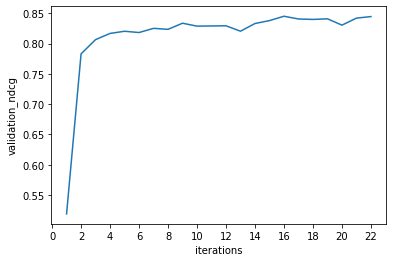

In [ ]:
def train_base_recommendation():
    losses_all=[]
    ndcgs=[]
    if gpu:
        device = torch.device('cuda:%s' % cuda)
    else:
        device = 'cpu'
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path,dataset + "_dataset_obj.pickle"), 'wb') as outp:
    #     pickle.dump(rec_dataset, outp, pickle.HIGHEST_PROTOCOL)

    train_loader = DataLoader(dataset=UserItemInterDataset(rec_dataset.training_data, 
                                rec_dataset.user_feature_matrix, 
                                rec_dataset.item_feature_matrix),
                          batch_size=64,
                          shuffle=True)
    model = BaseRecModel(len(rec_dataset.features)).to(device)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    out_path = os.path.join("./logs", dataset + "_logs")
    Path(out_path).mkdir(parents=True, exist_ok=True)
    
    ndcg = compute_ndcg(rec_dataset.validation_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('init ndcg:', ndcg)
    for epoch in tqdm.trange(epochs):
        model.train()
        optimizer.zero_grad()
        losses = []
        # print(len(train_loader))
        for user_behaviour_feature, item_aspect_feature, label in train_loader:
            user_behaviour_feature = user_behaviour_feature.to(device)
            item_aspect_feature = item_aspect_feature.to(device)
            label = label.float().to(device)
            out = model(user_behaviour_feature, item_aspect_feature).squeeze()
            # print(out)
            if len(out.size())==0:
              continue
            # print(user_behaviour_feature)
            # print( item_aspect_feature)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.to('cpu').detach().numpy())
            ave_train = np.mean(np.array(losses))
            losses_all.append(ave_train)
        print('epoch %d: ' % epoch, 'training loss: ', ave_train)
      
        # compute necg
        if epoch % 1 == 0:
            ndcg = compute_ndcg(rec_dataset.validation_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
            print('epoch %d: ' % epoch, 'training loss: ', ave_train, 'NDCG_validation: ', ndcg)

            ndcgs.append(ndcg)
    torch.save(model.state_dict(), os.path.join(save_path2, "model_withoutTips.model"))
    ndcg_test = compute_ndcg(rec_dataset.test_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('\nndcg_test: ',ndcg_test)
    # plt.xlabel('iterations')
    # plt.ylabel('train_loss')
    # plt.xticks(np.arange(0,len(losses_all),100))
    # plt.plot(np.arange(0,len(losses_all)),losses_all)
    # plt.show()

    plt.xlabel('iterations')
    plt.ylabel('validation_ndcg')
    plt.xticks(np.arange(-2,len(ndcgs)+2,2))
    plt.plot(np.arange(1,len(ndcgs)+1),ndcgs)
    plt.show()
    return rec_dataset


if __name__ == "__main__":
    torch.manual_seed(0)
    np.random.seed(0)
    if gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] =cuda
        print("Using CUDA",cuda)
    else:
        print("Using CPU")
    rec_dataset=train_base_recommendation()

# Save Train and Test Data To File

In [ ]:
training_data=[]
for train_data in rec_dataset.training_data:
  user=train_data[0]
  item=train_data[1]
  label=train_data[2]
  user_id=rec_dataset.inv_user_name_dict[user]
  item_id=rec_dataset.inv_item_name_dict[item]
  training_data.append([user_id,item_id,label])

In [ ]:
np.savetxt('training_data_2.txt', training_data, fmt='%s')
b = np.loadtxt('training_data_2.txt',dtype=str)

In [ ]:
import pickle
pet_stats = {'name':"", 'int':1, 'bool':False}

def pet_save(pet,name):
    with open('{}_data_2.pickle'.format(name), 'wb') as f:
        pickle.dump(pet, f, pickle.HIGHEST_PROTOCOL)

def digimon_load():
    with open('test_data.pickle', 'rb') as f:
        return pickle.load(f)

In [ ]:
testing_data={}
for ts_data in rec_dataset.test_data:
  user=ts_data[0]
  items=ts_data[1]
  labels=ts_data[2]
  # print(user , item, label)
  user_id=rec_dataset.inv_user_name_dict[user]
  items_id=[rec_dataset.inv_item_name_dict[item] for item in items]
  testing_data[user_id]=[items_id,labels]

In [ ]:
pet_save(testing_data,'test')

In [ ]:
validation_data={}
for ts_data in rec_dataset.validation_data:
  user=ts_data[0]
  items=ts_data[1]
  labels=ts_data[2]
  # print(user , item, label)
  user_id=rec_dataset.inv_user_name_dict[user]
  items_id=[rec_dataset.inv_item_name_dict[item] for item in items]
  validation_data[user_id]=[items_id,labels]

In [ ]:
pet_save(validation_data,'validation')

# Generate Explanations

In [ ]:
dataset="yelp"
base_model_path="/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/Yelp/"
gpu=True
cuda='0'
data_obj_path="/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/Yelp/"
rec_k=5
lam=100
gam=0.5
alp=0.2
user_mask=False
lr=0.4
step=500
mask_thresh=0.3
test_num=-1
# save_path="./explanation_objs/"

In [ ]:
import torch
import pickle
import os
from pathlib import Path

# User Perspective Features

In [ ]:
import json
import nltk

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
def lemmatization(text):
    result=''
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
        # if pos in ['n','a']:   
        result+=wordnet.lemmatize(token,pos)+' '
    return result
def remove_stopwords(text):
    en_stopwords = stopwords.words('english')
    en_stopwords+=['may','could','that','without','iii','with','and','This','That','Those','These','the','The','brbr','so','it','such']
    result = []
    for token in text:
        if token not in en_stopwords:
            result.append(token)
            
    return result
def remove_punct(text):
    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(text))
    return lst

def remove_tag(text):
    text=' '.join(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def preprocess(text):
  chars=['&','%','#','@','^','>','<','\n','\\','\t',';','"','/']
  stwords=stopwords.words('english')
  for ch in chars:
    text=text.replace(ch,' ')
  text=" ".join(text.split())
  # text=text.lower()
  text_tokenized=word_tokenize(text)
  cleaned_text= remove_stopwords(text_tokenized)
  cleaned_text= remove_punct(cleaned_text)
  # cleaned_text=lemmatization(cleaned_text)
  cleaned_text=remove_tag(cleaned_text)
  cleaned_text=remove_urls(cleaned_text)
  cleaned_text=''.join([i for i in cleaned_text ])
  cleaned_text=[word for word in cleaned_text.split(' ') if len(word)>1]
  # print(cleaned_text)
  return ' '.join(cleaned_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def preprocess_text_first(text):
  while '<' in text and '>' in text and text.index('<')<text.index('>'):
    toRemove=text[int(text.index('<')):int(text.index('>'))]+'>'
    text=text.replace(toRemove,' ')
  list_to_replace=['mso','gte','xml','false','#',',','!','-','\'','\"','[',']','/','\\n','\\','span','a-size-base','a-color-secondary','input type','header name','value','=','<a href= javascript:void(0) class= ','{','}','class=','header','<a href= javascript:void(0)','<','>','href',')','(',';','quot','&',':','javascript']
  for char in list_to_replace:
    text=text.replace(char,' ')
  for i in range(15):
    text=text.replace('  ',' ')
  # while 'if' in text and 'endif' in text and text.index('if')<text.index('endif'):
  #   # print(int(text.index('if')),int(text.index('endif')))
  #   toRemove=text[int(text.index('if')):int(text.index('endif'))]+'endif'
  #   text=text.replace(toRemove,' ')
  new_text=''
  for word in text.split(' '):
    if len(word)>1 and len(word)<35:
      new_text+=word+' '
  # new_text=lemmatization(new_text)
  # print(new_text)
  return new_text

In [ ]:
items_list1=[]
users_list=[]
review_features={}
f=open(save_path+'Yelp')
lines=f.readlines()
i=0
for line in lines:
  if i%100000==0:
    print(i)
  i+=1
  user_id = line.split('@')[0]
  item_id = line.split('@')[1]
  # if item_id in items_list:
  users_list.append(user_id)
  items_list1.append(item_id)
  l = len(user_id) + len(item_id)
  fosr_data = line[l+3:]
  for seg in fosr_data.split('||'):
    if (user_id,item_id) not in review_features.keys():
      review_features[(user_id,item_id)]=[]
    fos = seg.split(':')[0].strip('|')
    if len(fos.split('|')) > 1:
          feature = fos.split('|')[0]
          opinion = fos.split('|')[1]
          sentiment = fos.split('|')[2]
          sentence= seg.split(':')[1]
          if sentiment=='+1':
            senti=1
          else:
            senti=-1
          review_features[(user_id,item_id)].append([feature,opinion,senti,sentence])
    else:
      print(user_id,item_id)

0
100000
200000
300000
400000
500000
1Xw_npZXLcsWBvlLYCiW_A fKrmWy4GFsrgdOYhN9pyZA
600000
700000
800000
900000
1000000
1100000
1200000
1300000


In [ ]:
print(len(review_features))

1130440


In [ ]:
user_test_perspective={}
i=0
for (user_id , item_id) in review_features.keys():
  review_feature=review_features[(user_id,item_id)]
  if i%50000==0:
    print(i)
  i+=1
  for features in review_feature:
    sentence=features[3]
    sentence=preprocess_text_first(sentence)
    sentence=preprocess(sentence).lower()
    if (user_id , item_id) not in user_test_perspective.keys():
      final_vect=[]
    final_vect+=sentence.split(' ')
    for word in sentence.split(' '):
      # tokens=list(set(df_words[df_words['word']==word]['tokenized'].values))
      # for token in tokens:
        final_vect+=word.split(' ')
    final_vect=list(set(final_vect))
    new_final_vect=[]
    for word in final_vect:
      if len(word)>1:
        new_final_vect.append(word)
    user_test_perspective[(user_id , item_id)]=new_final_vect

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000


# Train Explanation Generation Model...

In [ ]:
temp_min =1.0
ANNEAL_RATE = 0.00003
class ExpOptimizationModel(torch.nn.Module):
    def __init__(self, base_model, rec_dataset, device):
        super(ExpOptimizationModel, self).__init__()
        self.base_model = base_model
        self.rec_dataset = rec_dataset
        self.device = device
        self.u_i_exp_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        self.user_feature_matrix = torch.from_numpy(self.rec_dataset.user_feature_matrix).to(self.device)
        self.item_feature_matrix = torch.from_numpy(self.rec_dataset.item_feature_matrix).to(self.device)
        self.rec_dict, self.user_perspective_test_data = self.generate_rec_dict()
        self.dict_items_cf_feature={}

    def generate_rec_dict(self):
        rec_dict = {}
        correct_rec_dict = {}  # used for user-side evaluation
        for row in self.rec_dataset.test_data:
            user = row[0]
            items = row[1]
            labels = row[2]
            # items1=[]
            # labels1=[]
            user_id=rec_dataset.inv_user_name_dict[user]
            for j in range(len(items)):
                item=items[j]
                label=labels[j]
                item_id=rec_dataset.inv_item_name_dict[item]    
                # if (user_id,item_id) in user_test_perspective.keys():
                #   items1.append(item)
                #   labels1.append(label)
            correct_rec_dict[user] = []
            user_features = self.user_feature_matrix[user].repeat(len(items), 1)
            scores = self.base_model(user_features,
                        self.item_feature_matrix[items]).squeeze()
            scores = np.array(scores.to('cpu'))
            # print(scores)
            sort_index = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True)
            
            sorted_items = [items[i] for i in sort_index]
            # print(sorted_items)
            # print(np.sort(scores))
            rec_dict[user] = sorted_items
            for i in range(rec_k):  # find the correct items and add to the user side test data
                # print(len(labels1))
                # print(len(labels))
                # print(sort_index[i])
                if labels[sort_index[i]] == 1:
                    correct_rec_dict[user].append(items[sort_index[i]])

        user_perspective_test_data = {}  # {(u, i):f, (u, i): f]}
        # for user, items in correct_rec_dict.items():
        #     for item in items:
        #         user_id=rec_dataset.inv_user_name_dict[user]
        #         item_id=rec_dataset.inv_item_name_dict[item]
        #         if (user_id,item_id) in user_test_perspective.keys():
        #           feature = user_test_perspective[(user_id, item_id)]
        #           user_perspective_test_data[(user, item)] = feature
        return rec_dict, user_perspective_test_data
    def user_side_evaluation(self):
        ave_pre, ave_rec, ave_f1 = evaluate_user_perspective(self.user_perspective_test_data, self.u_i_exp_dict)
        print('user\'s perspective:')
        print('ave pre: ', ave_pre, '  ave rec: ', ave_rec, '  ave f1: ', ave_f1)
        return ave_pre,ave_rec,ave_f1
    
    def model_side_evaluation(self):
        ave_pn, ave_ps, ave_fns = evaluate_model_perspective(
            self.rec_dict,
            self.u_i_exp_dict,
            self.base_model,
            self.rec_dataset.user_feature_matrix,
            self.rec_dataset.item_feature_matrix,
            rec_k,
            self.dict_items_cf_feature,
            self.device)
        print('model\'s perspective:')
        print('ave PN: ', ave_pn, '  ave PS: ', ave_ps, '  ave F_{NS}: ', ave_fns)  
        return ave_pn , ave_ps , ave_fns
    def generate_explanation(self,lr,temp,a,b,c):
        # u_i_exps_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        exp_nums = []
        exp_complexities = []
        self.no_exp_count = 0
        self.exp_count=0
        if test_num == -1:
            test_num1 = len(list(self.rec_dict.items()))
        else:
            test_num1 = test_num
        count=0
        for user, items in tqdm.tqdm(list(self.rec_dict.items())[:10]):
            count+=1
            # if count<200:
            #   continue
            # if count==2:
            #   break
            items = self.rec_dict[user]
            margin_item = items[rec_k]
            margin_score = self.base_model(self.user_feature_matrix[user].unsqueeze(0), 
                            self.item_feature_matrix[margin_item].unsqueeze(0)).squeeze()
            # print('margin_score:',margin_score)
            if margin_score>0:
            # if user_mask:
            #     # mask_vec = self.generate_mask(user)
            #     mask_vec = torch.where(self.user_feature_matrix[user]>0, 1., 0.).unsqueeze(0)  # only choose exps from the user cared aspects
            # else:
                
              for item in items[: rec_k]:
                  item_id=rec_dataset.inv_item_name_dict[item]
                  # print(item_id)
                  
                  main_score = self.base_model(self.user_feature_matrix[user].unsqueeze(0), 
                              self.item_feature_matrix[item].unsqueeze(0)).squeeze()
                  # print('main_score:',main_score)
                  # print(self.item_feature_matrix[item])
                  # tensor_vect_desc,tensor_vect_title,tensor_vect_feature=get_tensor_vects(item_id)
                  # self.dict_items_cf_feature[item]=(tensor_vect_desc,tensor_vect_title,tensor_vect_feature)
                  # print(tensor_vect_desc.shape)
                  # print(tensor_vect_title.shape)
                  # print(tensor_vect_feature.shape)
                  explanation_features,exp_num = self.explain(user,item,
                      self.user_feature_matrix[user], 
                      self.item_feature_matrix[item], 
                      margin_score,
                      lr, temp,a,b,c)
                  # or (len(explanation_features[0][0])<3 and len(explanation_features[2][0])==0)
                  if explanation_features==None or len(explanation_features)==0 :
                      # print('no explanation for user %d and item %d' % (user, item))
                      self.no_exp_count += 1
                  else:
                      self.exp_count+=1
                      self.u_i_exp_dict[(user, item)] = explanation_features
                      # print(explanation_features_words)
                      exp_nums.append(exp_num)
                      # exp_complexities.append(exp_complexity)
              # if count%500==0:
              #   json1 = json.dumps(self.u_i_exp_dict)
              #   f = open("drive/MyDrive/ranjbar/dict{}.json".format(count),"w")
              #   f.write(json1)
              #   f.close()

              
        print('ave num: ', np.mean(exp_nums),  'no_exp_count: ', self.no_exp_count, 'exp_count: ', self.exp_count)
        return  np.mean(exp_nums), self.no_exp_count,  self.exp_count
    
    def explain(self,user,item, user_feature, item_feature, margin_score, lr, temp,a, b, c):
        self.exp_generator = EXPGenerator(
            self.rec_dataset, 
            self.base_model, 
            user_feature, 
            item_feature, 
            user,
            item,
            margin_score,
            self.device).to(self.device)
        # optimization
        optimizer = torch.optim.SGD(self.exp_generator.parameters(), lr=lr, weight_decay=0)
        self.exp_generator.train()
        lowest_loss = None
        lowest_bpr = None
        optimized_pi1= None
        optimized_pi2= None
        # optimized_pi3= None
        optimized_delta= None
        explanation_features_words_replaced=[]
        # temp=1.0
        score = self.exp_generator(temp)
        # print(score)
        bpr, l11,l12,l14,l2,main_loss = self.exp_generator.loss(a,b,c,score)
        # print('init: ', 0, '  train loss: ', loss, '  bpr: ', bpr, '  l2: ', l2, '  l1: ', l1)
        lowest_loss = main_loss
        lowest_bpr=bpr
        optimize_pi1 = self.exp_generator.pi1
        optimize_pi2 = self.exp_generator.pi2
        # optimize_pi3 = self.exp_generator.pi3
        optimize_delta = self.exp_generator.delta

        for epoch in range(step):
            self.exp_generator.zero_grad()
            score = self.exp_generator(temp)
            bpr, l11,l12,l14,l2,main_loss = self.exp_generator.loss(a,b,c,score)
            # break
            if epoch %10==0:
               temp = np.minimum(temp * np.exp(-ANNEAL_RATE * epoch), temp)
            # if epoch %100 == 0:
            #    print(
            #         'temp',temp,
            #         'epoch', epoch,
            #         'bpr: ', bpr,
            #         'loss', main_loss,
            #          'l11',l11,
            #          'l12',l12,
            #         #  'l13',l13,
            #          'l14',l14,
            #          'l2',l2
            #          )

            main_loss.backward(retain_graph=True)
            # bpr.backward(retain_graph=True)
            # l1.backward(retain_graph=True)

            optimizer.step()
            if main_loss < lowest_loss:
                lowest_loss = main_loss
                lowest_bpr = bpr
                optimize_pi1 = self.exp_generator.pi1
                optimize_pi2 = self.exp_generator.pi2
                # optimize_pi3 = self.exp_generator.pi3
                optimize_delta = self.exp_generator.delta
        # print(lowest_bpr)
        # print(lam * alp)
        # print(optimize_delta)
        if lowest_bpr >= a * alp:
            explanation_features_continues = None 
            exp_num = None
            exp_complexity = None
            explanation_features=None
            explanation_features_replaced=None
        else:
            # optimize_delta = self.exp_generator.delta.detach().to('cpu').numpy()
            # print(optimize_delta)
            new_features_not_scaled=[]
            item_feature1 = torch.clamp(
            (self.exp_generator.continues_features_values[0] +torch.clamp(optimize_delta[0],-0.00001,0.00001)),
             torch.tensor(self.exp_generator.min_feature1).to(device), torch.tensor(self.exp_generator.max_feature1).to(device))
            item_feature2 = torch.clamp(
            (self.exp_generator.continues_features_values[1] +torch.clamp(optimize_delta[1],-0.00001,0.00001)),
             torch.tensor(self.exp_generator.min_feature2).to(device), torch.tensor(self.exp_generator.max_feature2).to(device))
            
            # explanation_features = np.argwhere(np.abs(optimize_delta.detach().to('cpu').numpy()) > 0.00001 ).squeeze(axis=1)
            # print(explanation_features)
            # print(self.exp_generator.main_pi1.shape)
            # print(torch.argmax(self.exp_generator.main_pi1,axis=1))
            # print(torch.argmax(self.exp_generator.main_pi1,axis=1))
            # print(self.exp_generator.main_pi1)
            # print(optimize_pi1)

            features_inds1=torch.argmax(self.exp_generator.main_pi1,axis=1)
            new_features_inds1=torch.argmax(optimize_pi1,axis=1)

            # features_inds2=torch.argmax(self.exp_generator.main_pi2,axis=1)
            # new_features_inds2=torch.argmax(optimize_pi2,axis=1)

            features_inds2=torch.argmax(self.exp_generator.main_pi2,axis=1)
            new_features_inds2=torch.argmax(optimize_pi2,axis=1)
            # print(self.exp_generator.main_pi1)
            # print(optimize_pi1)
            inds1=torch.where(new_features_inds1!=features_inds1)[0]
            inds2=torch.where(new_features_inds2!=features_inds2)[0]
            # print(features_inds3)
            # print(new_features_inds3)
            # print(inds3)
            col_names = ['latitude','longitude']
            y_new=[item_feature1.detach().to('cpu').numpy(),item_feature2.detach().to('cpu').numpy()]
            for ind in inds1:
              # print('attribute:',all_attributes[ind])
              col_names.append(all_attributes[ind])
              y_new.append(self.exp_generator.attributes_matrix[new_features_inds1[ind]][ind].detach().to('cpu').numpy())
              # print('old_value:',self.exp_generator.attributes_matrix[features_inds1[ind]][ind])
              # print('new_value:',self.exp_generator.attributes_matrix[new_features_inds1[ind]][ind])
            # for ind in inds2:
              # print('category: ',all_categories[ind])
              # print('old_value:',self.exp_generator.categories_matrix[features_inds2[ind]][ind])
              # print('new_value:',self.exp_generator.categories_matrix[new_features_inds2[ind]][ind])
            for ind in inds2:
              # print(all_days_hours)
              # print('day_hour: ',all_days_hours[ind])
              col_names.append(all_days_hours[ind])
              y_new.append(self.exp_generator.days_hours_matrix[new_features_inds2[ind]][ind].detach().to('cpu').numpy())
              # print('old_value:',self.exp_generator.days_hours_matrix[features_inds2[ind]][ind])
              # print('new_value:',self.exp_generator.days_hours_matrix[new_features_inds2[ind]][ind])

            new_features_not_scaled+=y_new
            features = business_df[col_names]
            scaler = preprocessing.StandardScaler().fit(features.values)
            new_features = scaler.inverse_transform(np.array(y_new).reshape(1,-1))
            old_features = business_df[business_df['business_id']==rec_dataset.inv_item_name_dict[item]][col_names]
            # print(old_features)
            # print(new_features[0])

            explanation_features=[[old_features,new_features[0]],new_features_not_scaled]

            # main_features_tips=self.exp_generator.features_tips
            # new_features_inds3=torch.argmax(optimize_pi3,axis=1)
            # # print(torch.sort(optimize_pi))
            # # print(torch.sort(exp_generator.pi))
            # # print(torch.sort(exp_generator.main_pi))
            # new_features3=[self.exp_generator.replaced_words[i] for i in new_features_inds3]
            # # print(main_features)
            # # print(new_features)
            # explanation_features_words= [main_features_tips[i] for i in range(len(main_features_tips)) if main_features_tips[i] != new_features3[i]]
            # explanation_features_words_replaced=[new_features3[i] for i in range(len(main_features_tips)) if main_features_tips[i] != new_features3[i]]
            # print(torch.sort(optimize_pi))
            # print(torch.sort(exp_generator.pi))
            # print(torch.sort(exp_generator.main_pi))
            # new_features=[self.exp_generator.replaced_words[i] for i in new_features_inds]
            # print(main_features)
            # print(new_features)
            # explanation_features_words= [main_features[i] for i in range(len(main_features)) if main_features[i] != new_features[i]]
            # explanation_features_words_replaced=[new_features[i] for i in range(len(main_features)) if main_features[i] != new_features[i]]
            # print([main_features[i].tolist() for i in explanation_features_inds[0]])
            # print(new_features[explanation_features_inds[0]])
            # print(main_features[explanation_features_inds[0]])
            
            # explanation_features_words=main_features[explanation_features_inds[0]]
            # print(explanation_features_words)
            # print(explanation_features_words_replaced)
            # explanation_features.append([explanation_features_words,explanation_features_words_replaced])
            # print('-------------\n')
            # new_vect=[]
            # for word in explanation_features_words:
            #   new_vect+=(str(word).split(' '))
            # new_vect=list(set(new_vect))
            # new_vect=[word for word in new_vect if len(word)>1]
            # explanation_features_words=new_vect
            exp_num = len(explanation_features[0][1])
            # exp_complexity = lowest_l2.to('cpu').detach().numpy() + gam * exp_num
        return explanation_features,exp_num
    


In [ ]:
def get_all_logits(len_features,df_desc,main_words):
  len_words=len(main_words)
  all_logits=np.zeros((len_words,len_features))
  j=0
  len_desc=0
  for i, row in df_desc.iterrows():
    len_desc+=1
    if row['word'] != main_words[j]:
      j+=1
    all_logits[j][i]=row['logit']
  
  return all_logits

In [ ]:
def get_replaced_words_vects(item_id):
    replaced_words=[]
    replaced_logits=[]
    replaced_vects=[]
    words_indices=[]
    main_words=[]
    i=0

    df_vect_desc_item= pd.read_json(save_path+'tips_bert_items_dfs/'+'{}.json'.format(item_id))
    replaced_words_desc=df_vect_desc_item['replaced_word'].values
    vects_desc=df_vect_desc_item['vect'].values
    replaced_words=list(replaced_words_desc)

    vects1=[sub_list for sub_list in  vects_desc]
    replaced_vects=vects1
    replaced_vects=torch.FloatTensor(replaced_vects).to(device)

    df_vect_desc_item1=df_vect_desc_item.copy()
    df_vect_desc_item1['main_word']=np.where(df_vect_desc_item1['replaced_word'] == df_vect_desc_item1['word'],1,0)
    df_vect_desc_item1=df_vect_desc_item1[df_vect_desc_item1['main_word']==1]
    if df_vect_desc_item1.empty:
      df_vect_desc_item1=df_vect_desc_item.copy()
      df_vect_desc_item1['main_word']=np.where(df_vect_desc_item1['logit']==5.0,1,0)
      df_vect_desc_item1=df_vect_desc_item1[df_vect_desc_item1['main_word']==1]
    if df_vect_desc_item1.empty:
      df_vect_desc_item1=df_vect_desc_item.copy()
      df_vect_desc_item1['main_word']=np.where(df_vect_desc_item1['logit']==12.0,1,0)
      df_vect_desc_item1=df_vect_desc_item1[df_vect_desc_item1['main_word']==1]
    indexes=df_vect_desc_item1.index
    main_words=list(df_vect_desc_item1['word'].values)
    for ind in indexes:
      words_indices.append(i+ind)
    i=df_vect_desc_item.shape[0]
    
    replaced_logits= get_all_logits(len(replaced_words),df_vect_desc_item,main_words)
    final_logits_tensor=torch.FloatTensor(replaced_logits).to(device)
    return replaced_words,replaced_vects,final_logits_tensor,words_indices

In [ ]:
def get_new_item_vector(replaced_vects,item,item_feature_name,pi):
    # print(pi.shape)
    # print(replaced_vects)
    # print(pi)
    final_vector=torch.mm(pi,replaced_vects)
    desc_vect=final_vector

    if len(desc_vect)>0:
      average_descriptions=torch.mean(desc_vect,axis=0).to(device)
    else:
      average_descriptions=torch.zeros(768).to(device)
    # print(final_vector)
    # final_vect=np.array(final_vector, dtype='float32')
    return average_descriptions

In [ ]:
scaled_features['latitude'].max()

3.015325457098988

In [ ]:
from matplotlib.transforms import ScaledTranslation
class EXPGenerator(torch.nn.Module):
    def __init__(self, rec_dataset, base_model, user_vect, item_vect,user,item, margin_score, device):
        super(EXPGenerator, self).__init__()
        self.rec_dataset = rec_dataset
        self.base_model = base_model
        self.user_vect = user_vect
        self.item_vect= item_vect
        self.margin_score = margin_score
        self.device = device
        self.features=rec_dataset.features
        self.len_features=len(self.features)
        # self.features_tips=rec_dataset.tips_features[item][0]
        # self.len_features_tips=len(self.features_tips)
        self.item=item
        self.user=user
        self.max_feature1=scaled_features['latitude'].max()
        self.min_feature1=scaled_features['latitude'].min()
        self.max_feature2=scaled_features['longitude'].max()
        self.min_feature2=scaled_features['longitude'].min()
        # self.max_feature3=scaled_features['stars'].max()
        # self.min_feature3=scaled_features['stars'].min()
        self.attributes_matrix,self.days_hours_matrix=get_features_matrix()
        # print(self.attributes_matrix.shape)
        # print(self.attributes_matrix)
        self.continues_features_values,self.features_attributes,self.features_days_hours,self.values_attributes,self.values_days_hours=get_features_indices(rec_dataset.inv_item_name_dict[item])
        # print(self.features_days_hours)
        # print(self.values_days_hours)
        teta_par1=get_initialized_teta(self.values_attributes,self.attributes_matrix,16.0)
        # print(teta_par1)
        # print(self.values_attributes)
        # print(self.attributes_matrix)
        # print('----------')
        teta_par2=get_initialized_teta(self.values_days_hours,self.days_hours_matrix,16.0)
        # self.replaced_words,self.replaced_vects,self.logits_tensor,self.words_indices=get_replaced_words_vects(rec_dataset.inv_item_name_dict[item])
        # self.logits_tensor=torch.where(self.logits_tensor==12.0,torch.tensor(-0.1).to(device),self.logits_tensor).to(device)
        # self.logits_tensor=torch.where(self.logits_tensor==5.0,torch.tensor(-0.1).to(device),self.logits_tensor).to(device)
        # self.logits_tensor=torch.where(self.logits_tensor==0.0,torch.tensor(-1.0).to(device),self.logits_tensor).to(device)
        # print(self.logits_tensor)
        # self.feature_range = [0, 1]  # hard coded, should be improved later
        # print(self.features)
        # teta_par3=get_initialized_teta2(self.features_tips,len(self.replaced_words),self.words_indices,12.0)
        
       
      
        self.teta1 =  torch.nn.Parameter(teta_par1)
        self.teta2 =  torch.nn.Parameter(teta_par2)
        # self.teta3 =  torch.nn.Parameter(teta_par3)
        self.delta = torch.nn.Parameter(torch.FloatTensor(2).uniform_(-0.0001, 0.0001))
        # print(self.attributes_matrix)
        
        self.main_pi1 = F.softmax((self.teta1 + self.sample_gumbel((self.attributes_matrix.shape[1],self.attributes_matrix.shape[0]))) /1.0, dim=-1)
        self.main_pi2 = F.softmax((self.teta2 + self.sample_gumbel((self.days_hours_matrix.shape[1],self.days_hours_matrix.shape[0]))) /1.0, dim=-1)
        # print(self.main_pi1)
        # self.main_pi3 = F.softmax((self.teta3 + self.sample_gumbel((self.len_features_tips,len(self.replaced_words)))) /0.000000000001, dim=-1)
        # self.main_pi=torch.clamp((self.teta), 0,1)
        # print(self.features)

        self.item=item
        self.user=user
    
    def get_masked_item_feature(self,temp):
        # item_feature_name=self.features_tips
        # print(self.teta1)
        
        self.pi1 = F.softmax((self.teta1 + self.sample_gumbel((self.attributes_matrix.shape[1],self.attributes_matrix.shape[0]))) /temp, dim=-1)
        self.pi2 = F.softmax((self.teta2 + self.sample_gumbel((self.days_hours_matrix.shape[1],self.days_hours_matrix.shape[0]))) /temp, dim=-1)
        # self.pi3 = F.softmax((self.teta3 + self.sample_gumbel((self.len_features_tips,len(self.replaced_words)))) /temp, dim=-1)
  
        # item_feature_tip=get_new_item_vector(self.replaced_vects,self.item,item_feature_name,self.pi3)

        item_feature1 = torch.clamp(
            (self.continues_features_values[0] +torch.clamp(self.delta[0],-0.00001,0.00001)),
             torch.tensor(self.min_feature1).to(device), torch.tensor(self.max_feature1).to(device))
        item_feature2 = torch.clamp(
            (self.continues_features_values[1] +torch.clamp(self.delta[1],-0.00001,0.00001)),
             torch.tensor(self.min_feature2).to(device), torch.tensor(self.max_feature2).to(device))
        # item_feature3 = torch.clamp(
        #     (self.continues_features_values[2] + self.delta[2]),
        #      torch.tensor(self.min_feature3).to(device),torch.tensor(self.max_feature3).to(device))
        # item_feature1=self.continues_features_values[0]
        # item_feature2=self.continues_features_values[1]
        # item_feature3=self.continues_features_values[2]
        # print(self.attributes_matrix)
        item_feature_4=torch.mm(self.pi1,self.attributes_matrix)
        item_feature_4=torch.diagonal(item_feature_4, 0)
        # print(item_feature_4)
        # print('--------------')
        # item_feature_5=torch.mm(self.pi2,self.categories_matrix)
        # item_feature_5=torch.diagonal(item_feature_5, 0)
        item_feature_5=torch.mm(self.pi2,self.days_hours_matrix)
        item_feature_5=torch.diagonal(item_feature_5, 0)
        # print(item_feature_tip)
        # print(np.shape(item_feature_tip))
        # item_feature_star=torch.concat([torch.Tensor([item_feature1]).to(device),torch.Tensor([item_feature2]).to(device),item_feature_4,item_feature_5])
        item_feature_star=torch.concat([torch.Tensor([item_feature1]).to(device),torch.Tensor([item_feature2]).to(device),item_feature_4,item_feature_5])
        # if self.item==311 and temp>1.4:
        #   print(scaled_features[scaled_features['business_id']==rec_dataset.inv_item_name_dict[313]])
        #   print(item_feature_star.detach().cpu().numpy())
        #   print(rec_dataset.item_feature_matrix[self.item])
        #   print(np.abs(item_feature_star.detach().cpu().numpy()-rec_dataset.item_feature_matrix[self.item]))
        #   # print()
        #   print('---------')
        # break
        # print(item_feature_4.shape)
        # print(item_feature_5.shape)
        # print(item_feature_6.shape)
        # print(item_feature_star.shape)
        
        return item_feature_star

    def sample_gumbel(self,shape, eps=1e-20):
      U = torch.rand(shape)
      U = U.cuda()
      return -torch.log(-torch.log(U + eps) + eps)
    
    def forward(self,temp):
        # print('temp',temp)
        item_feature_star = self.get_masked_item_feature(temp)
        # print('item_feature_star: ')
        # print(item_feature_star)
        # print('item_vect: ')
        # print(self.item_vect)
        score = self.base_model(self.user_vect.unsqueeze(0), item_feature_star.unsqueeze(0))
        # print(score)
        return score
    
    def loss(self, a,b,c, score):
        # print(score)
        # print(self.margin_score)
        bpr = torch.nn.functional.relu(alp + score - self.margin_score) * a

        l11 = torch.linalg.norm(self.main_pi1-self.pi1,ord=1)*1.0
        l12 = torch.linalg.norm(self.main_pi2-self.pi2,ord=1)*1.0
        # l13 = torch.linalg.norm(self.main_pi3-self.pi3,ord=1)*1.0
        l14 = torch.linalg.norm(self.delta,ord=1)*1.0

        l2=torch.linalg.norm(self.delta)*1.0
        loss=bpr+l2+l14
        return bpr, l11,l12,l14,l2,loss

In [ ]:
def evaluate_user_perspective(user_perspective_data, u_i_expl_dict):
    pres = []
    recs = []
    f1s = []
    for u_i, gt_features in user_perspective_data.items():
        if u_i in u_i_expl_dict:
            pre_features = u_i_expl_dict[u_i][2][0]
            if len(pre_features)>0:
              TP = 0
            # print('f: ', gt_features, pre_features)
              for feature in pre_features:
                  if feature in gt_features:
                      TP += 1
              # print(gt_features)
              # print(pre_features)
              pre = TP / len(pre_features)
              rec = TP / len(gt_features)
              if (pre + rec) != 0:
                  f1 = (2 * pre * rec) / (pre + rec)
              else:
                  f1 = 0
              pres.append(pre)
              recs.append(rec)
              f1s.append(f1)
    ave_pre = np.mean(pres)
    ave_rec = np.mean(recs)
    ave_f1 = np.mean(f1s)
    return ave_pre, ave_rec, ave_f1

In [ ]:
def get_tensor_vect_df(df,not_in_columns):
  df1=df.copy()
  df1['main_word']=np.where(df1['replaced_word'] == df1[not_in_columns],1,0)
  df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==5.0,1,0)
    df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==12.0,1,0)
    df1=df1[df1['main_word']==1]
  lists=df1.loc[:, ~df1.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
  words=df1[not_in_columns].values
  # print(words)
  vects=[sub_list[0] for sub_list in lists]
  tensor_vect=torch.FloatTensor(vects).to(device)
  return tensor_vect

In [ ]:
def get_tensor_vects(item_id):
  tensor_vect_desc=None
  # print(item_id)
  # if os.path.exists(save_path+'descriptions_bert/'+'df_bert_desc_{}.json'.format(item_id)) :
  df_vect_tip= pd.read_json(save_path+'tips_bert_items_dfs/'+'{}.json'.format(item_id))
  # df_vect_desc=df_vect[0]
  tensor_vect_tip=get_tensor_vect_df(df_vect_tip,'word')
  return tensor_vect_tip

In [ ]:
def get_average_vect_test(weights,tensor_vect):
  # weights=torch.FloatTensor(weights).to(device)
  # weights=torch.transpose(weights.repeat(tensor_vect.shape[1],1),0,1)
  # print(weights.shape)
  # print(tensor_vect.shape)
  # print('-------------')
  average=(torch.mul(weights,tensor_vect)/torch.sum(weights))[0].to(device)
  # print(average.shape)
  return average

In [ ]:
def get_new_item_vector2(item,new_weights):
    # item_id= rec_dataset.inv_item_name_dict[item]
    final_vector=[]
    # print(len(new_weights))
    # print(len(item_feature_name[0]))
    # print(tensor_vect_desc.shape)
    # print(new_weights.shape)
    # print(rec_dataset.item_feature_matrix[item][:].shape)
    # print('*************')
    average_vect_other_features= get_average_vect_test(new_weights[0:len(rec_dataset.features)],torch.FloatTensor(rec_dataset.item_feature_matrix[item][:].reshape(1,-1)).to(device))
    # average_vect_tips=get_average_vect_test(new_weights[len(rec_dataset.features):len(rec_dataset.features)+len(rec_dataset.tips_features)])
    # average_vect_feature=get_average_vect_test(new_weights[len(item_feature_name[0])+len(item_feature_name[1]):],tensor_vect_feature)
    # rank=normalized_rank[item_id]*new_weights[-1]
    final_vector=average_vect_other_features
    # print(len(final_vector))
    # final_vect=np.array(final_vector, dtype='float32')
    return final_vector

In [ ]:
list(scaled_features.columns).index('latitude')

1

In [ ]:
def sample_gumbel(shape, eps=1e-20):
      U = torch.rand(shape)
      U = U.cuda()
      return -torch.log(-torch.log(U + eps) + eps)
def evaluate_model_perspective(
        rec_dict,
        u_i_exp_dict,
        base_model,
        user_feature_matrix,
        item_feature_matrix,
        rec_k,
        dict_items_cf_feature,
        device):
    """
    compute PN, PS and F_NS score for the explanations
    :param rec_dict: {u1: [i1, i2, i3, ...] , u2: [i1, i2, i3, ...]}
    :param u_i_exp_dict: {(u, i): [f1, f2, ...], ...}
    :param base_model: the trained base recommendation model
    :param user_feature_matrix: |u| x |p| matrix, the attention on each feature p for each user u
    :param item_feature_matrix: |i| x |p| matrix, the quality on each feature p for each item i
    :param rec_k: the length of the recommendation list, only generated explanations for the items on the list
    :param device: the device of the model
    :return: the mean of the PN, PS and FNS scores
    """
    pn_count = 0
    ps_count = 0
    # df_vects=rec_dataset.df_vects
    # print(len( u_i_exp_dict))
    i=0
    count_all=0
    dict_items={}
    for u_i, fs in u_i_exp_dict.items():
        # if i%100==0:
        #   print(i)
        # i+=1
        # if i>15600 and i<16000: 
        #   continue
        user = u_i[0]
        target_item = u_i[1]
        features = fs
        items = rec_dict[user]
        target_index = items.index(target_item)
        
        new_features_not_scaled=features[1]
        # features_words=list(set(features[2][0]))
        # if len(features_words)>0 or len(new_features_not_scaled)>2:
        count_all+=1
        other_features=list(features[0][0].columns)
        # print(other_features)
        # print(len(items))

        # compute PN
        cf_items_features1 = []
        cf_items_features2 = []
        for item in items:
          # if item in dict_items.keys():
          #   replaced_words,replaced_vects,logits_tensor,words_indices=dict_items.get(item)
          # else:
          #   replaced_words,replaced_vects,logits_tensor,words_indices=get_replaced_words_vects(rec_dataset.inv_item_name_dict[item])
          #   dict_items[item]=(replaced_words,replaced_vects,logits_tensor,words_indices)

          # item_id=rec_dataset.inv_item_name_dict[item]
          # item_cf_feature1,item_cf_feature2=get_item_vector1(item,features,replaced_words,replaced_vects,logits_tensor,words_indices)
  
          # cf_items_features1.append(item_cf_feature1)
          # cf_items_features2.append(item_cf_feature2)
            item_id=rec_dataset.inv_item_name_dict[item]
            # all_features_words=rec_dataset.tips_features[item][0]
            # print(all_features)
            # print(features)
            # item_feature_words=rec_dataset.tips_features[item][0]
            item_feature_names=rec_dataset.features
            if len(new_features_not_scaled)<3:
              weights1=np.ones(len(item_feature_names))
              weights1[0:2]=0.0
              weights2=np.zeros(len(item_feature_names))
              weights2[0:2]=1.0
            else:
              weights1=[1.0,1.0]
              weights1+=[0.0 if fea in other_features else 1.0 for fea in item_feature_names[2:]]
              # weights1+=[0.0 if fea in features_words else 1.0 for fea in  item_feature_words]
              weights2=[1.0,1.0]
              weights2+=[1.0 if fea in other_features else 0.0 for fea in item_feature_names[2:]]
              # weights2+=[1.0 if fea in features_words else 0.0 for fea in  item_feature_words]
            weights1=torch.from_numpy(np.array(weights1,dtype='float32')).to(device)
            weights2=torch.from_numpy(np.array(weights2,dtype='float32')).to(device)
            # print(len(all_features))
            # print(all_features)
            # weights=torch.FloatTensor(weights).to(device)
            # if item in dict_items_cf_feature.keys():
            #   tensor_vect_tip=dict_items_cf_feature[item]
            # else:
            #   tensor_vect_tip=get_tensor_vects(item_id)
            #   dict_items_cf_feature[item]=tensor_vect_tip
            
            item_cf_feature1=get_new_item_vector2(item,weights1).detach().to('cpu').numpy()
            item_cf_feature2=get_new_item_vector2(item,weights2).detach().to('cpu').numpy()
            # print(item_cf_feature1)
            for col_i in range(2,len(other_features)):
              col_name=other_features[col_i]
              ind=list(scaled_features.columns).index(col_name)-1
              item_cf_feature1[ind]=new_features_not_scaled[col_i]
            # for col_i in range(2,len(other_features)):
            #   col_name=other_features[col_i]
            #   ind=list(scaled_features.columns).index(col_name)-1
            #   item_cf_feature2[ind]=new_features_not_scaled[col_i]
            # print(item_cf_feature1)
            cf_items_features1.append(item_cf_feature1)
            cf_items_features2.append(item_cf_feature2)

        cf_ranking_scores1 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features1))])
                                                            ).to(device),
                                          torch.from_numpy(np.array(cf_items_features1,dtype='float32')).to(device)).squeeze()
        cf_score_list1 = cf_ranking_scores1.to('cpu').detach().numpy()
        # print(np.sort( cf_score_list1)[::-1])
        sorted_index1 = np.argsort(cf_score_list1)[::-1]
        # print(sorted_index1)
        cf_rank1 = np.argwhere(sorted_index1 == target_index)[0, 0]  # the updated ranking of the current item
        # print(cf_rank1)
        if cf_rank1 > rec_k - 1:
            pn_count += 1
        # compute NS
        cf_ranking_scores2 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features2))])
                                                            ).to(device),
                                          torch.from_numpy(np.array(cf_items_features2,dtype='float32')).to(device)).squeeze()
        cf_score_list2 = cf_ranking_scores2.to('cpu').detach().numpy()
        sorted_index2 = np.argsort(cf_score_list2)[::-1]
        cf_rank2 = np.argwhere(sorted_index2 == target_index)[0, 0]  # the updated ranking of the current item
        if cf_rank2 < rec_k:
            ps_count += 1
    if len(u_i_exp_dict) != 0:
        pn = pn_count / count_all
        ps = ps_count / count_all
        if (pn + ps) != 0:
            fns = (2 * pn * ps) / (pn + ps)
        else:
            fns = 0
    else:
        pn = 0
        ps = 0
        fns = 0
    return pn, ps, fns

In [ ]:
a = torch.arange(60.)
b = torch.ones(60)
print(a.shape)
print(b.shape)
torch.mul(a,b)

torch.Size([60])
torch.Size([60])


tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59.])

In [ ]:
def generate_explanation():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    # import dataset
    
    base_model = BaseRecModel(len(rec_dataset.features)).to(device)
    base_model.load_state_dict(torch.load(os.path.join(save_path2,"model_withoutTips.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    # Create optimization model
   
    # lrs=[0.3,0.5,0.7,0.9]
    # temps=[1.5,2.0,2.5,3.0]
    a=100.0
    # bs=[1.0,2.0,10.0]
    # cs=[1000.0,2000.0,10000.0]
    lrs=[0.5]
    temps=[2.0]
    bs=[2.0]
    cs=[1000.0]
    with open(save_path+'result_validation.txt','w') as result_file:
      for lr in lrs:
        for temp in temps:
          for b in bs:
            for c in cs:
              print('lr:', lr , '   temp:', temp , '   l1_b:', b , 'cs:', c)
              opt_model = ExpOptimizationModel(base_model=base_model,rec_dataset=rec_dataset,device = device)
              ave_num,no_exp_count,exp_count=opt_model.generate_explanation(lr,temp,a,b,c)
              # ave_pre,ave_rec,ave_f1=opt_model.user_side_evaluation()
              ave_pn,ave_ps,ave_fns=opt_model.model_side_evaluation()
              # result_file.write(str(lr)+'#'+str(temp)+'#'+str(b)+'#'+str(c)+'#'+str(ave_num)+'#'+str(no_exp_count)+'#'+str(exp_count)+'#'+str(ave_pn)+'#'+str(ave_ps)+'#'+str(ave_fns))
              # result_file.write('\n')
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'wb') as outp:
    #     pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'rb') as opt:
    #     opt_model = pickle.load(opt)
            
    # print(opt_model.u_i_exp_dict)
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'wb') as outp:
    #     pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    return opt_model


if __name__ == "__main__":
    opt_model=generate_explanation()

cpu
lr: 0.5    temp: 2.0    l1_b: 2.0 cs: 1000.0


100%|██████████| 15/15 [02:31<00:00, 10.13s/it]


ave num:  2.6142857142857143 no_exp_count:  5 exp_count:  70
model's perspective:
ave PN:  0.6714285714285714   ave PS:  0.4142857142857143   ave F_{NS}:  0.5124060150375941


In [ ]:
print(rec_dataset.item_name_dict['0vTc7-wiDBDKKmGvC0EzFg'])
print(rec_dataset.item_name_dict['QbAZz0bNDECP9fKh2HXwEA'])
print(rec_dataset.item_name_dict['tU692E8N0xBQ7Ogc78gN2g'])
print(rec_dataset.item_name_dict['7JhQXpiMml41sxN34CUcKQ'])
print(rec_dataset.item_name_dict['_V6hl1oGkTV2KbGeax_HPA'])
print(rec_dataset.item_name_dict['tqmi9HYujFk3zphlLkyFUw'])

12469
2261
6988
3766
1379
4398


In [ ]:
rec_dataset.inv_item_name_dict[13200]

'pJtvP5aHophr2gjIVvX-YA'

 [[        latitude  longitude  soy-free
   45738  40.074097 -75.430998       0.0,
   array([ 40.07404047, -75.43085025,  -1.00000001])],

In [ ]:
business_df[business_df['business_id']=='pJtvP5aHophr2gjIVvX-YA']['attributes'].values

array([{'Ambience': "{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': True}", 'BusinessAcceptsCreditCards': 'True', 'GoodForKids': 'True', 'BikeParking': 'True', 'HasTV': 'False', 'NoiseLevel': "u'average'", 'Caters': 'True', 'RestaurantsAttire': "u'casual'", 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", 'RestaurantsPriceRange2': '2', 'Alcohol': "u'none'", 'WiFi': "u'no'", 'RestaurantsReservations': 'False', 'RestaurantsGoodForGroups': 'True', 'RestaurantsDelivery': 'None', 'GoodForMeal': "{'dessert': None, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}", 'RestaurantsTakeOut': 'None', 'OutdoorSeating': 'None'}],
      dtype=object)

In [ ]:
business_df[business_df['business_id']=='pJtvP5aHophr2gjIVvX-YA']['hours'].values

array([{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0', 'Wednesday': '11:0-20:0', 'Thursday': '11:0-20:0', 'Friday': '11:0-20:0', 'Saturday': '11:0-20:0', 'Sunday': '11:0-20:0'}],
      dtype=object)

(1120, 1321): [[       latitude  longitude  halal
   5472  36.103133   -86.8185    0.0,
   array([ 36.10318994, -86.81864752,  -0.99999997])],

(1097, 13448): [[        latitude  longitude  soy-free  Open24Hours
   24511  39.781303 -86.162359       0.0          0.0,
   array([ 39.78135986, -86.16221174,  -1.00000001,  -1.00000002])],

In [ ]:
opt_model.u_i_exp_dict

{(1717, 8101): [[        latitude  longitude  RestaurantsCounterService
   31476  29.963765 -90.057946                        0.0,
   array([ 29.96382196, -90.05779827,  -1.00000001])],
  [array(-1.13383102), array(-0.04697368), array(-54.841824, dtype=float32)]],
 (1717, 27406): [[        latitude  longitude  Open24Hours
   30162  29.960329 -90.063783          0.0,
   array([ 29.96027242, -90.06393083,   1.00000002])],
  [array(-1.13445425), array(-0.04738952), array(43.017372, dtype=float32)]],
 (1717, 23075): [[       latitude  longitude  glten-free
   43050  29.91637 -90.064801         0.0,
   array([ 29.91631256, -90.06465333,   1.00000001])],
  [array(-1.14217269), array(-0.04743851), array(51.67903, dtype=float32)]],
 (1717, 18204): [[        latitude  longitude  glten-free
   23544  29.981451  -90.10724         0.0,
   array([ 29.98150788, -90.10709253,   1.00000001])],
  [array(-1.13072574), array(-0.05031624), array(51.67903, dtype=float32)]],
 (1717, 3027): [[       latitude

In [ ]:
scaled_features.drop(['Unnamed: 0'],axis=1,inplace=True)

cpu
lr: 0.7    temp: 1.2    l1_b: 2.0 cs: 1000.0

100%|██████████| 500/500 [59:22<00:00,  7.13s/it]

ave num:  2.162861491628615 no_exp_count:  1843 exp_count:  657
model's perspective:
ave PN:  0.7138508371385084   ave PS:  0.45662100456621   ave F_{NS}:  0.5569707441912939

lr: 0.7    temp: 1.2    l1_b: 2.0 cs: 1000.0

100%|██████████| 500/500 [59:20<00:00,  7.12s/it]

ave num:  2.178060413354531 no_exp_count:  1871 exp_count:  629
model's perspective:
ave PN:  0.6947535771065183   ave PS:  0.5119236883942766   ave F_{NS}:  0.5894878836055307


cuda:0
lr: 0.5    temp: 2.0    l1_b: 2.0 cs: 1000.0

100%|██████████| 500/500 [1:24:16<00:00, 10.11s/it]

ave num:  2.601012231126107 no_exp_count:  129 exp_count:  2371
model's perspective:
ave PN:  0.579924082665542   ave PS:  0.5141290594685787   ave F_{NS}:  0.5450481547951392

cuda:0
lr: 0.5    temp: 2.0    l1_b: 2.0 cs: 1000.0

100%|██████████| 500/500 [1:24:32<00:00, 10.15s/it]

ave num:  2.8620527306967984 no_exp_count:  376 exp_count:  2124
model's perspective:
ave PN:  0.7142184557438794   ave PS:  0.4769303201506591   ave F_{NS}:  0.5719393641648616


In [ ]:
print(scaled_features[scaled_features['business_id']==rec_dataset.inv_item_name_dict[313]])
# print(item_feature_star.detach().cpu().numpy())
print(rec_dataset.item_feature_matrix[313])

In [ ]:
!nvidia-smi

Sat Dec  3 14:38:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |  11450MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
scaled_features[scaled_features['business_id']==rec_dataset.inv_item_name_dict[313]].values

array([['117cztVQvB0ujB7u_wsnqw', -1.4980904708431637,
        0.46681412305154973, -0.0376529817885355, 0.0,
        0.2119479010160372, 0.0, -0.04407956832248244,
        -0.5895735997856777, 0.20133638516134778, 0.00894350637861649,
        -1.2814712608788843, -0.01620751147108067, 1.5936217334538345,
        -0.012899065488495188, 0.004299370572541429, 0.8138050121286367,
        0.32550282083735993, 2.295358654302332, 1.4159386284550264,
        0.22495975578037114, -0.05833921949534602, 0.0,
        -1.280698281064274, 0.31877166147304414, 0.8107942224173016,
        0.008598979571271433, 0.0, 1.3612050440463725,
        0.20763369234843287, -1.4337871241891178, 0.0, 0.0,
        0.32405493998230156, 0.41376152647521236, 1.5300479087053305,
        0.0, 0.0013890341829850203, 0.0, 1.5861148011328192,
        -1.541012369633422, -1.155679248447159, -0.032877591967836184,
        0.2790486480582958, 0.12628650459915802, 1.1250852090965502,
        -1.2532262572886546, 0.2833420469

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2, 3'


In [ ]:
torch.cuda.empty_cache()

In [ ]:
gc.collect()

0

In [ ]:
scaled_features[scaled_features['business_id']=='cXSyVvOr9YRN9diDkaWs0Q']

,business_id,latitude,longitude,extensions,tesday,karaoke,crly,BusinessParking,GoodForKids,soy-free,...,Sunday-14,Sunday-15,Sunday-16,Sunday-17,Sunday-18,Sunday-19,Sunday-20,Sunday-21,Sunday-22,Sunday-23
5073,cXSyVvOr9YRN9diDkaWs0Q,0.617278,0.962269,-0.016158,0.199551,0.265498,-0.038524,0.0,1.081264,0.01214,...,0.682789,-1.406415,-1.366261,-1.203323,-1.045674,-0.964793,-0.837287,-0.638478,-0.45292,-0.386191


In [ ]:
rec_dataset.item_name_dict['cXSyVvOr9YRN9diDkaWs0Q']

87

In [ ]:
rec_dataset.item_feature_matrix[87]

array([ 6.1727804e-01,  9.6226919e-01, -6.2152386e-01,  1.4352431e+00,
        2.6718395e+00, -5.3733215e-02, -1.2551033e+00,  4.1024658e-01,
        1.2135880e-02, -1.2225970e+00, -1.3012578e+00, -6.4647146e-02,
        0.0000000e+00,  0.0000000e+00, -3.8524136e-02,  2.6754642e-01,
        1.1805184e+00,  4.0002968e-02,  1.2099340e-01,  4.5542073e+00,
        2.3202303e-01,  1.6083758e-01,  2.3357999e-01, -1.3787478e+00,
        9.2035896e-01,  1.6095901e+00,  1.4662104e+00,  0.0000000e+00,
        1.8960987e+00,  1.4208582e-01, -4.4105849e+00,  0.0000000e+00,
        7.4279788e-03,  0.0000000e+00,  1.6107263e-02,  1.1435419e+00,
       -1.2140231e-02,  1.8206900e-02,  8.4562075e-01, -1.9275221e+00,
        1.3727969e-02,  2.0366924e-01,  5.7547635e-01,  3.9616646e-03,
       -2.8771944e-02,  0.0000000e+00, -3.1991590e-02, -1.6311872e+00,
        3.1009293e-01,  4.0794546e-03,  0.0000000e+00, -4.9025949e-02,
        2.6549846e-01,  2.0782132e+00,  1.1929584e-01, -1.6151328e-02,
      

In [ ]:
scaled_features['extensions'].max()

10.813683527586809

In [ ]:
list(set(scaled_features.iloc[:,90].values))

[54.923122700510184, -54.91502985278389, 0.004046423863150696]

In [ ]:
len(user_test_perspective.keys())

1130440

# calculate Stability...

In [ ]:
def generate_explanation_check_stability():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    # import dataset
    # with open(os.path.join(data_obj_path, dataset + "_dataset_obj_4.pickle"), 'rb') as inp:
    #     rec_dataset = pickle.load(inp)
    
    base_model = BaseRecModel(len(rec_dataset.features)).to(device)
    base_model.load_state_dict(torch.load(os.path.join(save_path2,"model_withoutTips.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    
    # Create optimization model
    a=100.0
    # bs=[1.0,2.0]
    # cs=[1000.0,2000.0,10000.0]
    lr=0.5
    temp=2.0
    b=2.0
    c=1000.0
    features_found=[]
    for i in range(10):
      opt_model = ExpOptimizationModel(
        base_model=base_model,
        rec_dataset=rec_dataset,
        device = device,)
      opt_model.generate_explanation(lr,temp,a,b,c)
      features_found.append(opt_model.u_i_exp_dict)
      
    
    return features_found


if __name__ == "__main__":
    features_found=generate_explanation_check_stability()

cuda:0


100%|██████████| 10/10 [01:51<00:00, 11.18s/it]


ave num:  2.739130434782609 no_exp_count:  4 exp_count:  46


100%|██████████| 10/10 [01:48<00:00, 10.84s/it]


ave num:  2.6 no_exp_count:  5 exp_count:  45


100%|██████████| 10/10 [01:48<00:00, 10.82s/it]


ave num:  2.6818181818181817 no_exp_count:  6 exp_count:  44


100%|██████████| 10/10 [01:48<00:00, 10.83s/it]


ave num:  2.652173913043478 no_exp_count:  4 exp_count:  46


100%|██████████| 10/10 [01:47<00:00, 10.79s/it]


ave num:  2.7333333333333334 no_exp_count:  5 exp_count:  45


100%|██████████| 10/10 [01:48<00:00, 10.81s/it]


ave num:  2.7111111111111112 no_exp_count:  5 exp_count:  45


100%|██████████| 10/10 [01:48<00:00, 10.83s/it]


ave num:  2.6956521739130435 no_exp_count:  4 exp_count:  46


100%|██████████| 10/10 [01:47<00:00, 10.74s/it]


ave num:  2.6 no_exp_count:  5 exp_count:  45


100%|██████████| 10/10 [01:52<00:00, 11.28s/it]


ave num:  2.7954545454545454 no_exp_count:  6 exp_count:  44


100%|██████████| 10/10 [01:51<00:00, 11.13s/it]

ave num:  2.727272727272727 no_exp_count:  6 exp_count:  44


In [ ]:
dict_features={}
for iter_feas in features_found:
  for u_i in iter_feas.keys():
    feas=list(iter_feas[u_i][0][0].columns)
    # feas+=iter_feas[u_i][2][0]
    if u_i in dict_features.keys():
      dict_features[u_i].append(feas)
    else:
      dict_features[u_i]=[]
      dict_features[u_i].append(feas)

In [ ]:
dict_features

{(1717, 8101): [['latitude', 'longitude', 'dairy-free'],
  ['latitude', 'longitude', 'dairy-free'],
  ['latitude', 'longitude', 'dairy-free'],
  ['latitude', 'longitude', 'halal'],
  ['latitude', 'longitude', 'halal'],
  ['latitude', 'longitude', 'dairy-free'],
  ['latitude', 'longitude', 'dairy-free'],
  ['latitude', 'longitude'],
  ['latitude', 'longitude', 'dairy-free'],
  ['latitude', 'longitude', 'dairy-free']],
 (1717, 27406): [['latitude', 'longitude', 'vegetarian'],
  ['latitude', 'longitude', 'vegetarian'],
  ['latitude', 'longitude', 'vegetarian'],
  ['latitude', 'longitude', 'vegetarian'],
  ['latitude', 'longitude', 'vegetarian'],
  ['latitude', 'longitude', 'vegetarian'],
  ['latitude', 'longitude', 'vegetarian'],
  ['latitude', 'longitude'],
  ['latitude', 'longitude', 'vegetarian'],
  ['latitude', 'longitude', 'vegetarian']],
 (1717,
  23075): [['latitude',
   'longitude',
   'RestaurantsCounterService',
   'vegan'], ['latitude', 'longitude', 'glten-free'], ['latitude',


In [ ]:
stability=0
# count_all=0
for ui in dict_features.keys():
  features=dict_features[ui]
  stabs=0
  count=0
  if(len(features)>1):
    # count_all+=1
    for i in range(len(features)):
      for j in range(len(features)):
        if i != j:
          intersection = list(set(features[i]) & set(features[j]))
          union = list(set(features[i]) | set(features[j]))
          # print(features[i],features[j])
          # print(intersection)
          # print(union)
          count+=1
          stabs+=(len(intersection)/len(union))
    # print(stabs)
    # print(len(features)*(len(features)-1))
    # print((stabs/(len(features)*(len(features)-1))))
    stability+=(stabs/(9.0*10.0))

stability=stability/len(dict_features)
print(stability)

0.7793595679012343
